# Image Classification with ResNet50 and Feature Visualization
We'll create a complete example that:
1. Downloads a small subset of ImageNet data
2. Performs classification using pretrained ResNet50
3. Visualizes the internal features of the network

In [1]:
# !pip install torch torchvision pillow requests matplotlib numpy

In [2]:
import torch
import torchvision
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from collections import OrderedDict, defaultdict
import io

import os
import requests
from zipfile import ZipFile
from io import BytesIO

from pathlib import Path

Let's create a small ImageNet subset downloader using the Tiny-ImageNet dataset, which is a smaller version of ImageNet that's freely available. We'll use a small subset of classes to demonstrate the concept.

In [3]:
# # Download Tiny ImageNet subset (200 classes, 500 images per class)
# tiny_imagenet_url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
# response = requests.get(tiny_imagenet_url, stream=True)

In [4]:
# # Create a directory for the dataset if it doesn't exist
# data_dir = "tiny_imagenet_subset"
# os.makedirs(data_dir, exist_ok=True)
#
# # Extract only first 20 classes to save space
# with ZipFile(BytesIO(response.content)) as zip_file:
#     class_dirs = [name for name in zip_file.namelist()
#                   if name.startswith('tiny-imagenet-200/train/n') and name.endswith('/')][:20]
#
#     for class_dir in class_dirs:
#         file_list = [f for f in zip_file.namelist()
#                      if f.startswith(class_dir) and f.endswith('.JPEG')][:100]
#
#         for file_name in file_list:
#             target_path = Path(os.path.join(data_dir, os.path.join(data_dir, file_name.replace('/', '\\')))).parent
#             os.makedirs(target_path, exist_ok=True)
#
#             with zip_file.open(file_name) as source, \
#                     open(os.path.join(target_path, os.path.basename(file_name)), 'wb') as target:
#                 target.write(source.read())

In [5]:
data_dir = os.path.join("tiny_imagenet_subset", "tiny_imagenet_subset", 'tiny-imagenet-200', 'train')

In [6]:
# Update sample_images dictionary with local paths
sample_images = defaultdict(list)
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    if os.path.isdir(class_path):
        for img_file in os.listdir(os.path.join(class_path, 'images'))[:10]:  # Take first image from each class
            # sample_images[class_dir].append(os.path.join(class_path, 'images', img_file))
            sample_images[class_dir] = [os.path.join(class_path, 'images', img_file)]

In [7]:
class ImageNetSubset:
    def __init__(self, urls, transform=None):
        self.urls = [(k, v) for k in urls.keys() for v in urls[k]]
        self.transform = transform

    def __len__(self):
        return len(self.urls)

    def __getitem__(self, idx):
        label, url = self.urls[idx]

        image = Image.open(url).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Przykład użycia:
dataset = ImageNetSubset(sample_images)
for im, lab in dataset:
    if im is not None:
        print(im)
        print(lab)

<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0710>
n01443537
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0EC0>
n01774750
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907C09BE0>
n02056570
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF1DC0>
n02129165
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0170>
n02403003
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907C09BE0>
n02410509
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0FB0>
n02769748
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0710>
n02814533
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907C09BE0>
n03584254
<PIL.Image.Image image mode=RGB size=64x64 at 0x11907CF0EC0>
n04259630


In [8]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Create dataset and dataloader
dataset = ImageNetSubset(sample_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [9]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.features = OrderedDict()
        self.hooks = []

        for name, layer in model.named_modules():
            if isinstance(layer, torch.nn.Conv2d):
                self.hooks.append(
                    layer.register_forward_hook(
                        # lambda name, m, i, o: self.features.update({name: o})
                        lambda name, m, o: self.features.update({name: o})
                    )
                )

    def get_features(self, input_tensor):
        self.features.clear()
        _ = self.model(input_tensor)
        return self.features

    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()

In [10]:
def visualize_features(feature_maps, num_features=8, save_path=None, title="Feature Maps Visualization"):
    plt.figure(figsize=(20, 12))
    plt.suptitle(title, fontsize=16, y=0.95)

    # Normalize across all feature maps for consistent visualization
    feature_maps_np = feature_maps[0].detach().cpu().numpy()
    feature_maps_min = feature_maps_np.min()
    feature_maps_max = feature_maps_np.max()

    for idx in range(min(num_features, feature_maps.shape[1])):
        plt.subplot(2, 4, idx + 1)
        plt.imshow(feature_maps[0, idx].detach().cpu().numpy(), cmap='viridis')
        # Normalize each feature map to [0,1] range
        feat_map = (feature_maps_np[idx] - feature_maps_min) / (feature_maps_max - feature_maps_min)
        plt.imshow(feat_map, cmap='magma')
        plt.axis('off')
        plt.title(f'Feature Map {idx + 1}')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()
# Example usage:


Processing images:   0%|          | 0/5 [00:00<?, ?it/s]

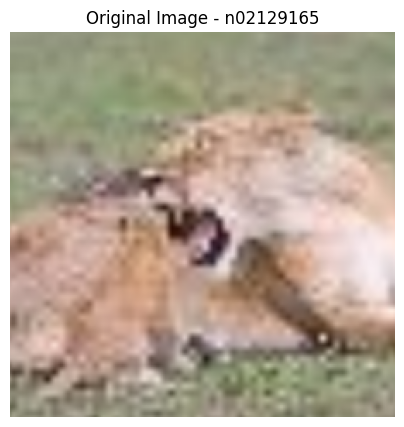


Predictions for n02129165:
291: 27.92%
293: 19.32%
276: 4.64%

Feature maps for n02129165:

Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


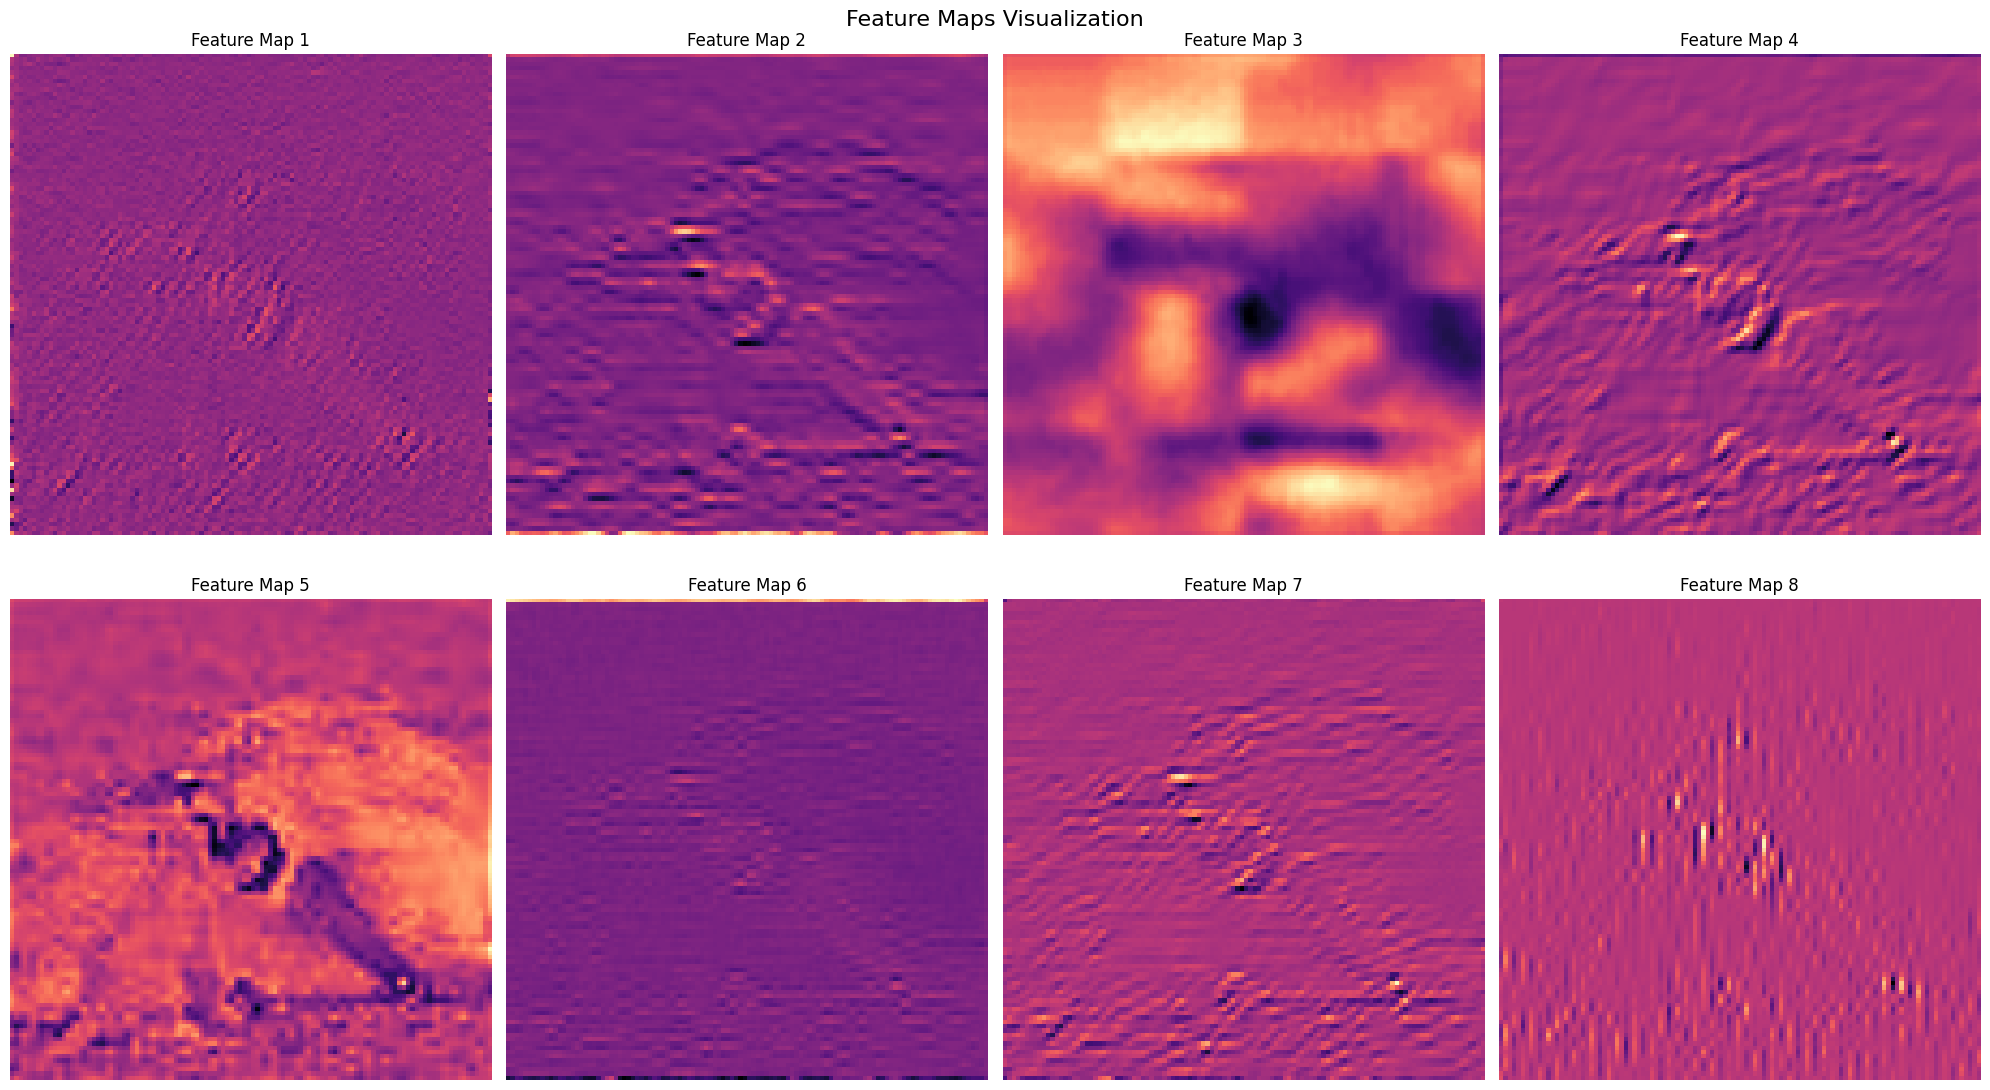

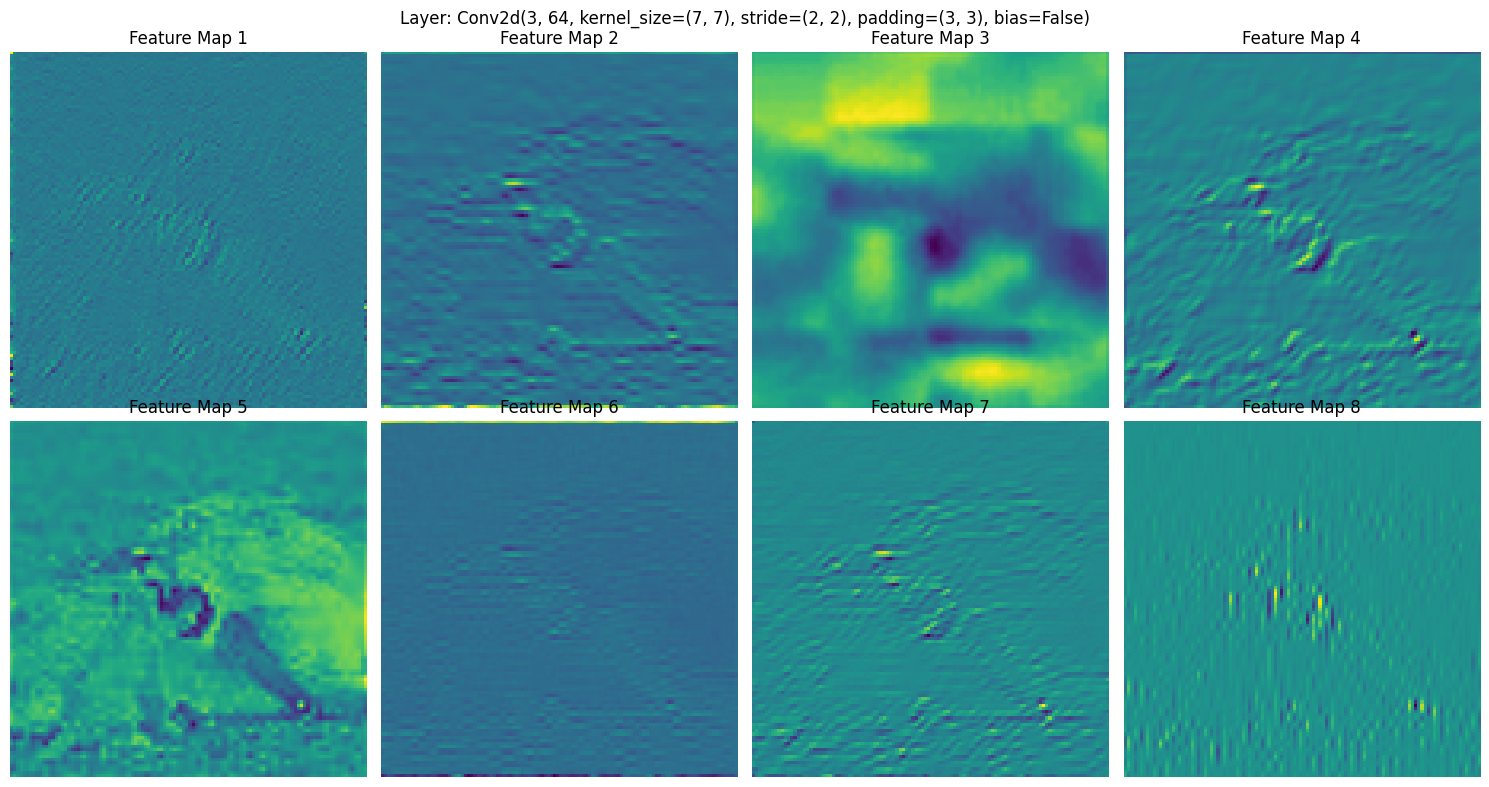


Layer: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


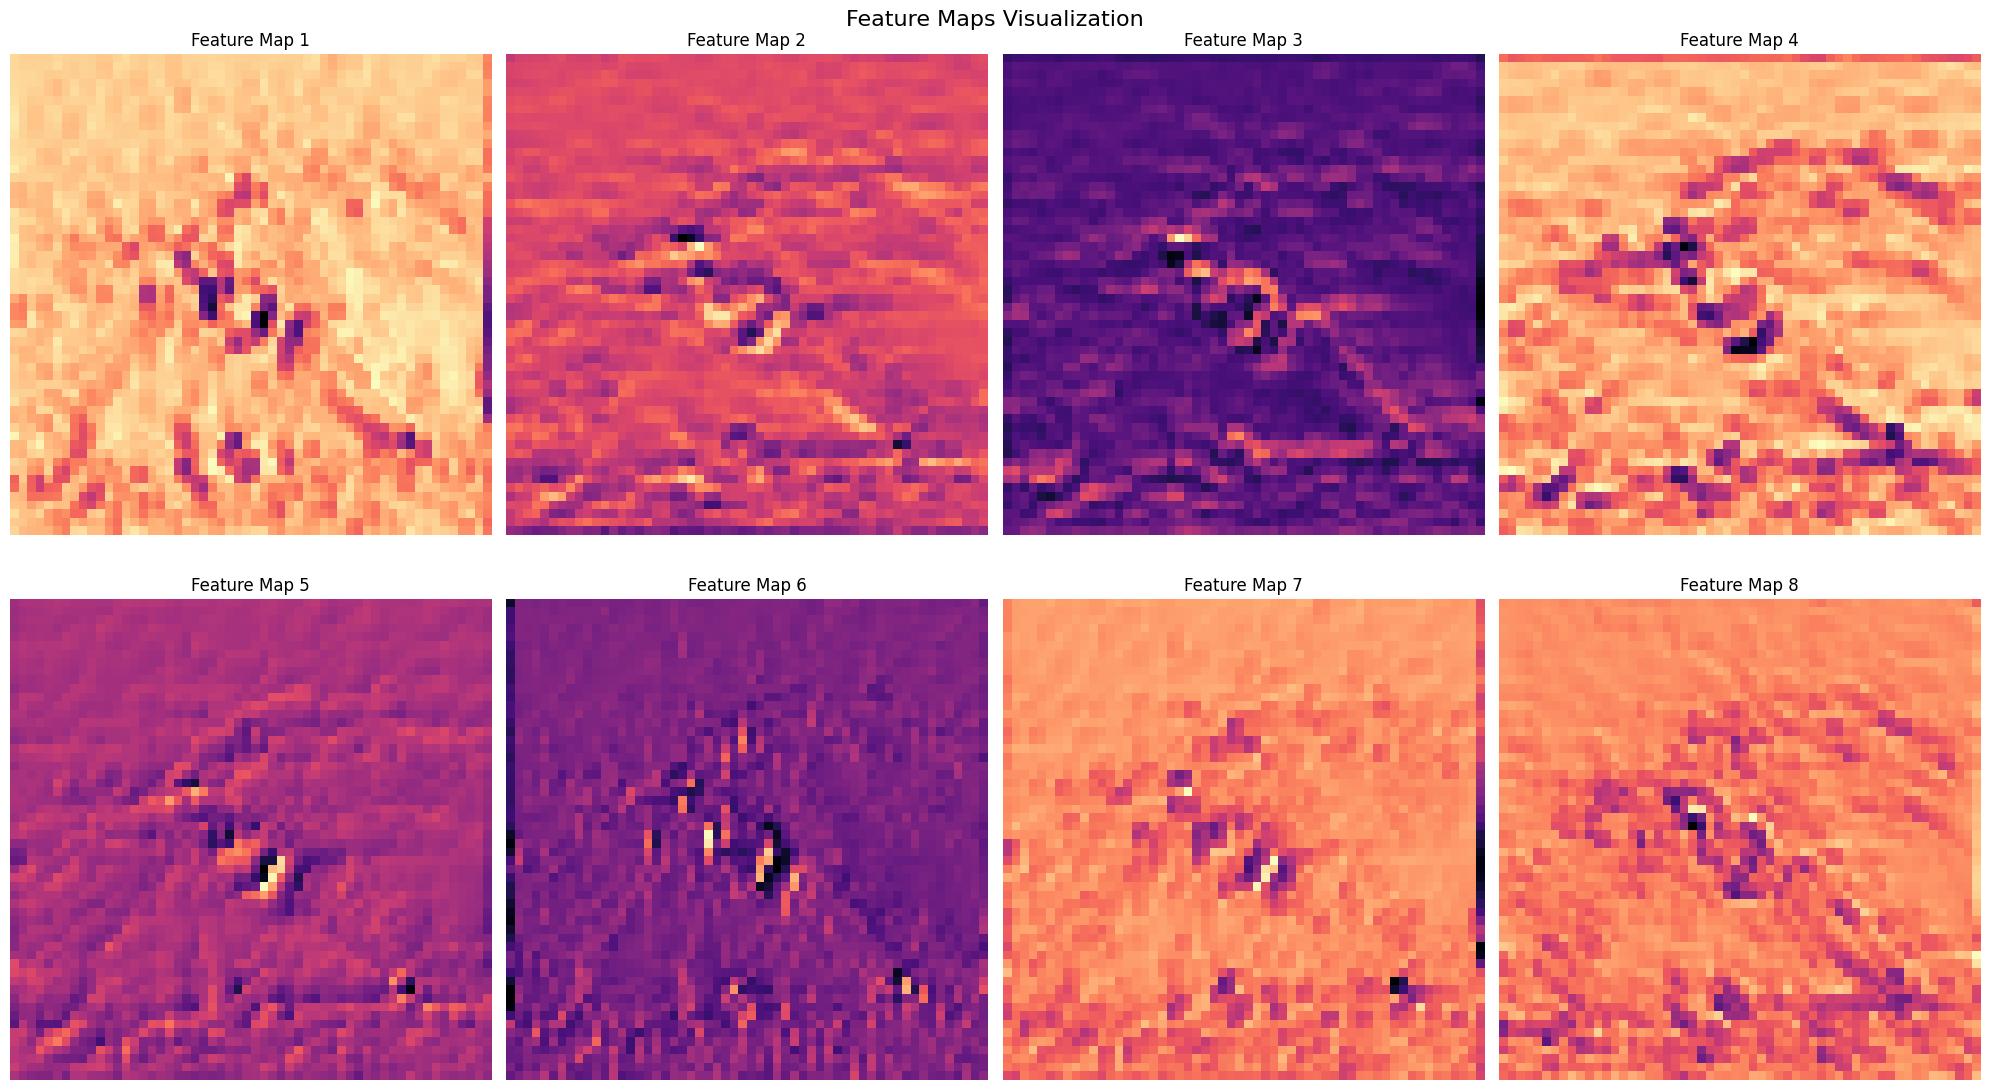

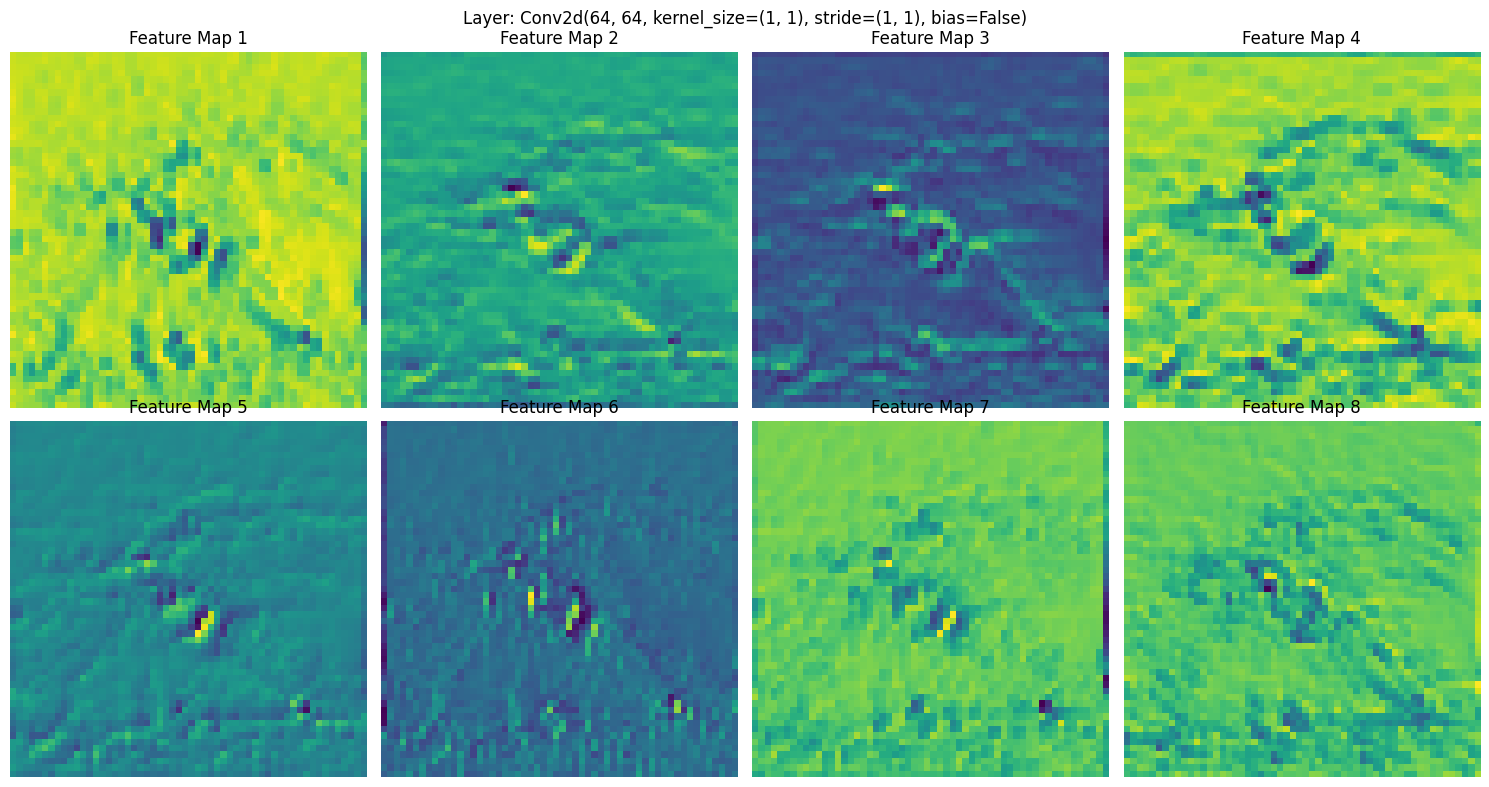


Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


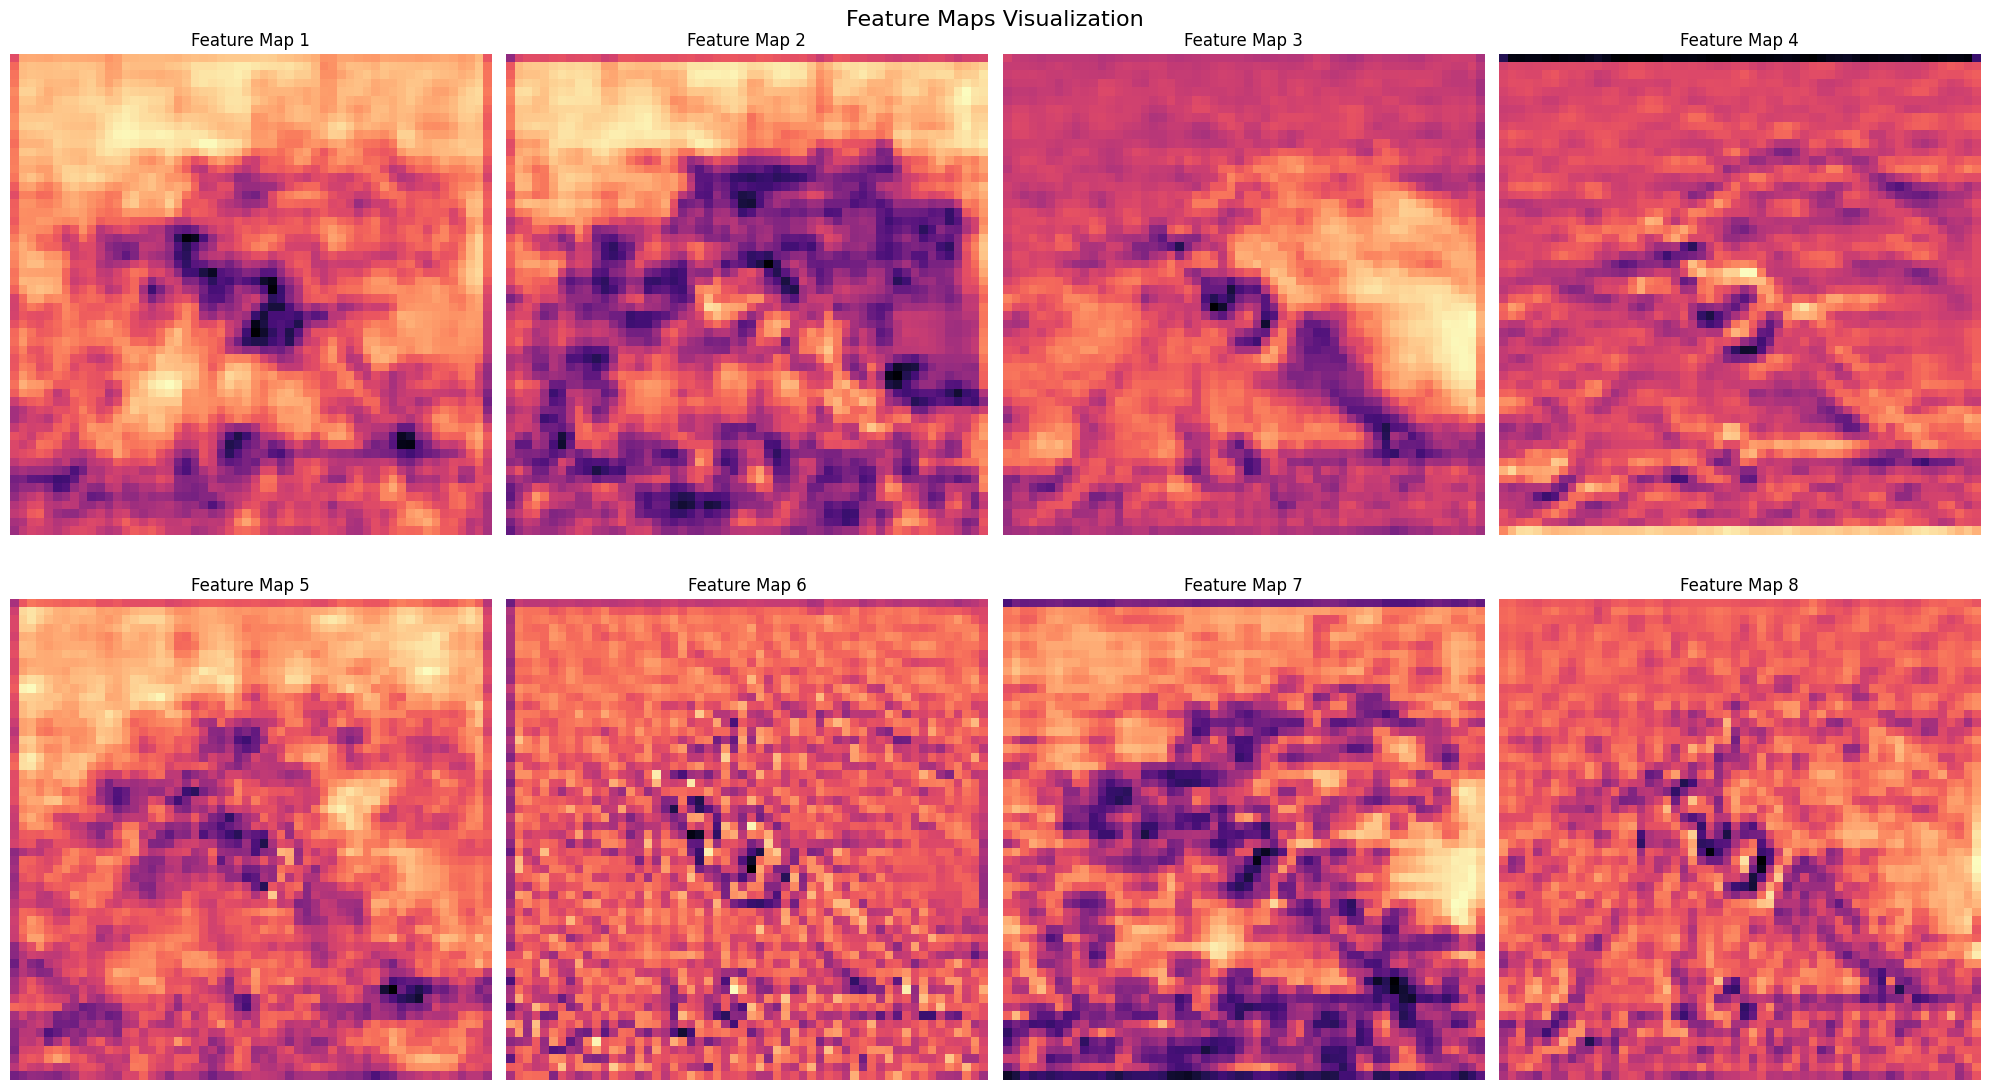

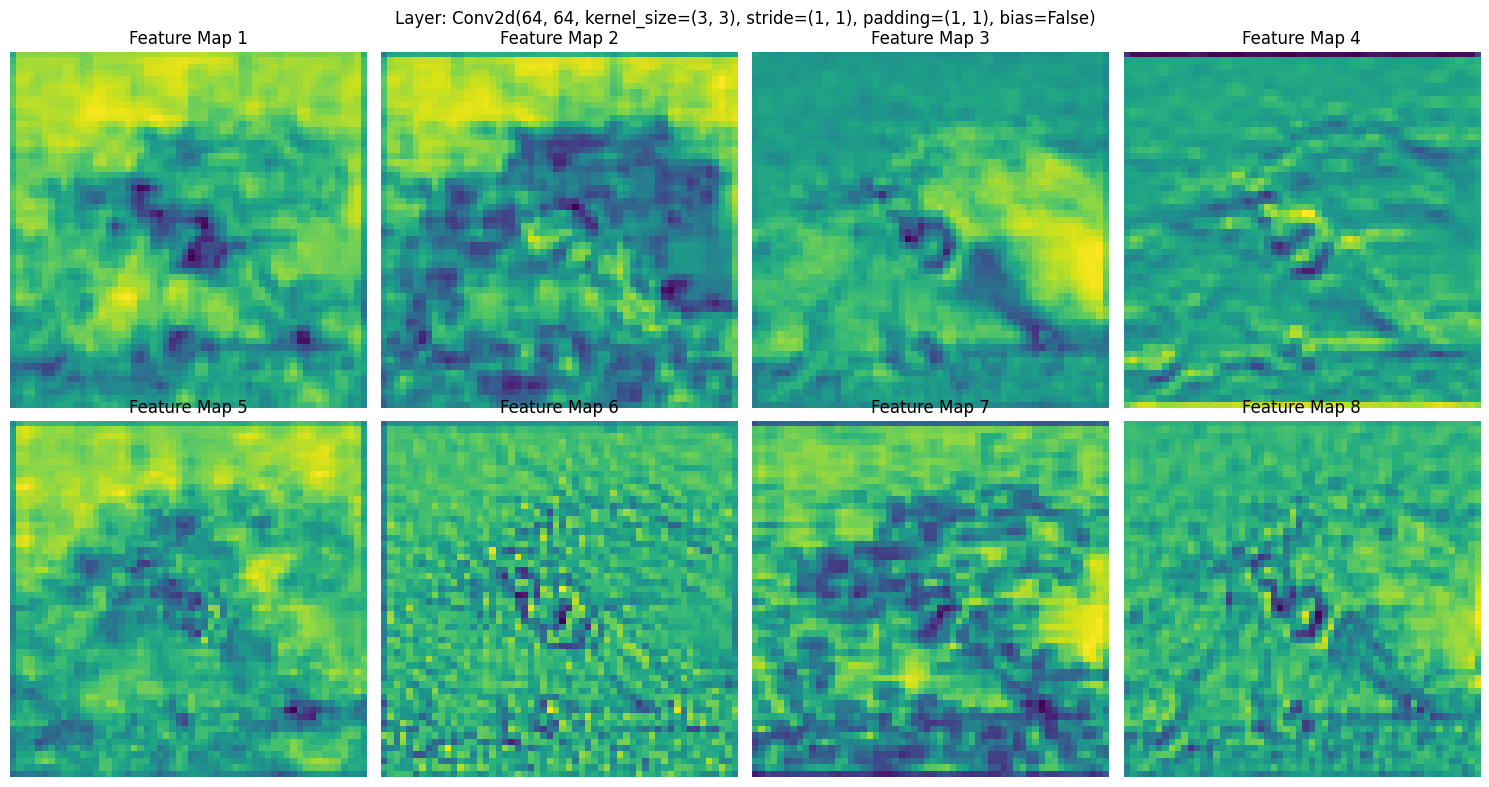


Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


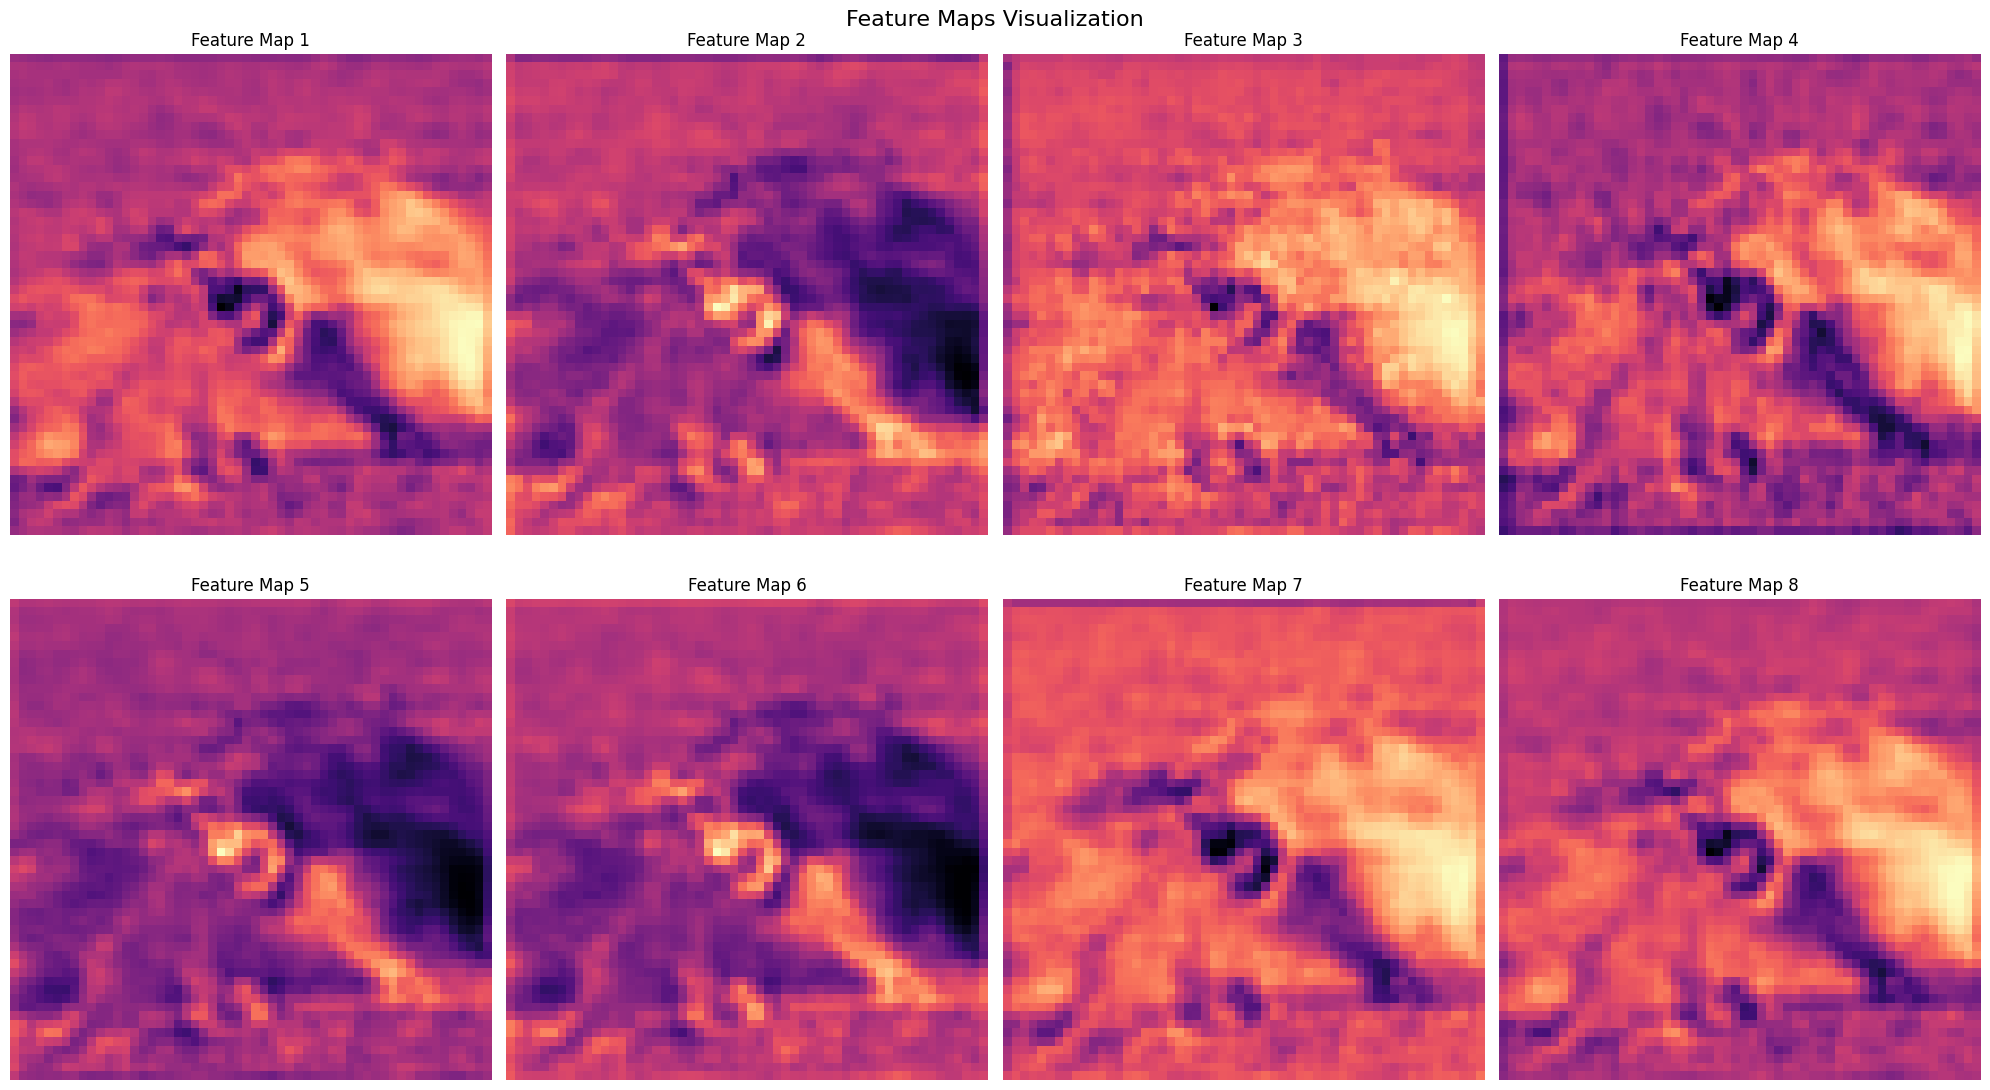

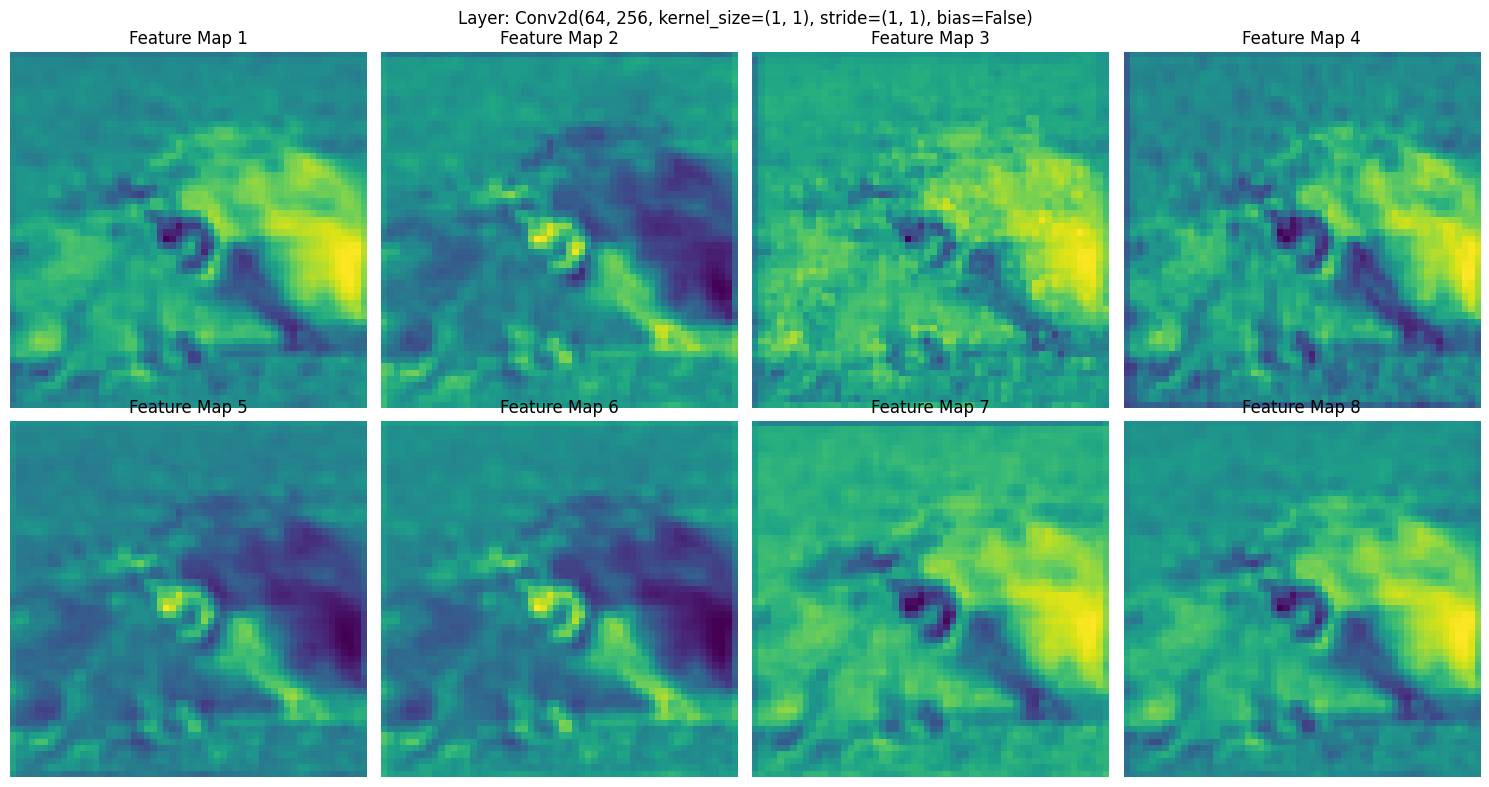


Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


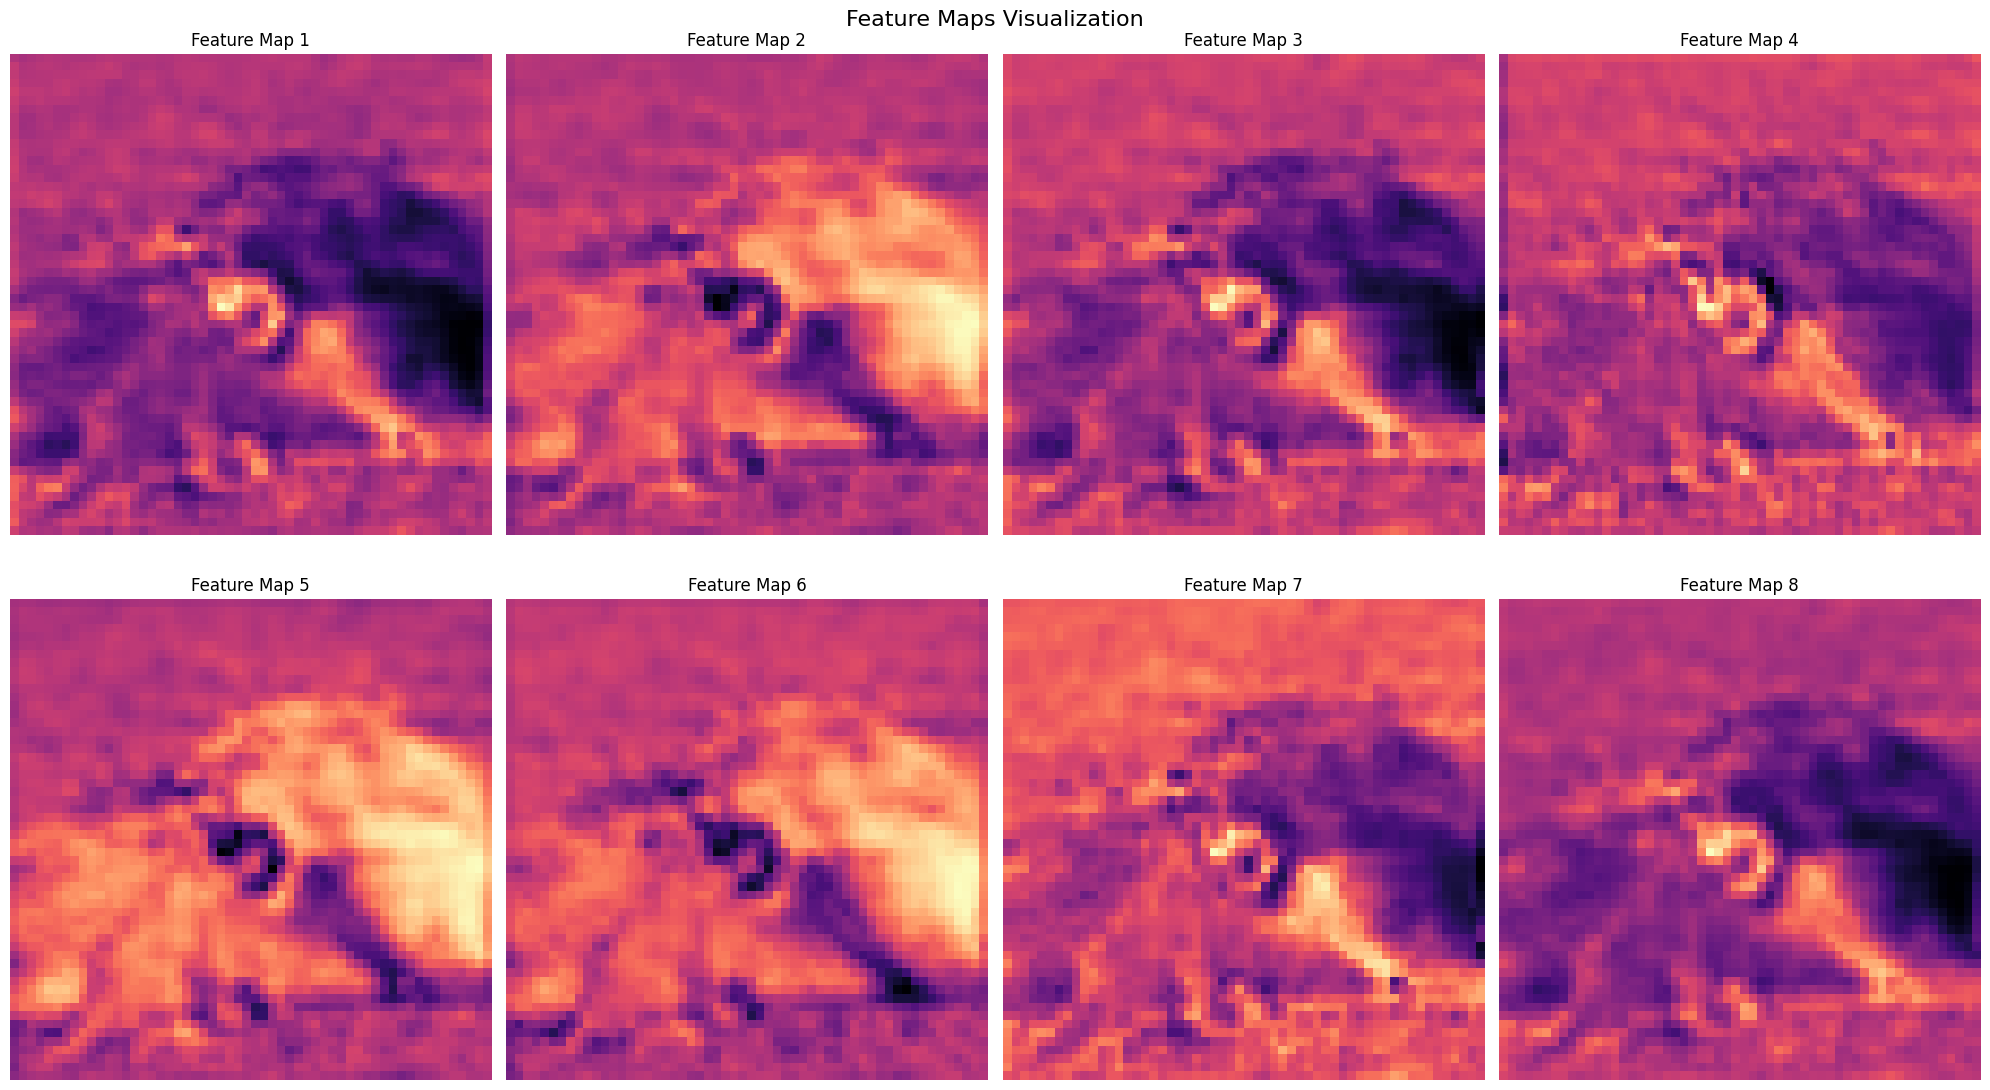

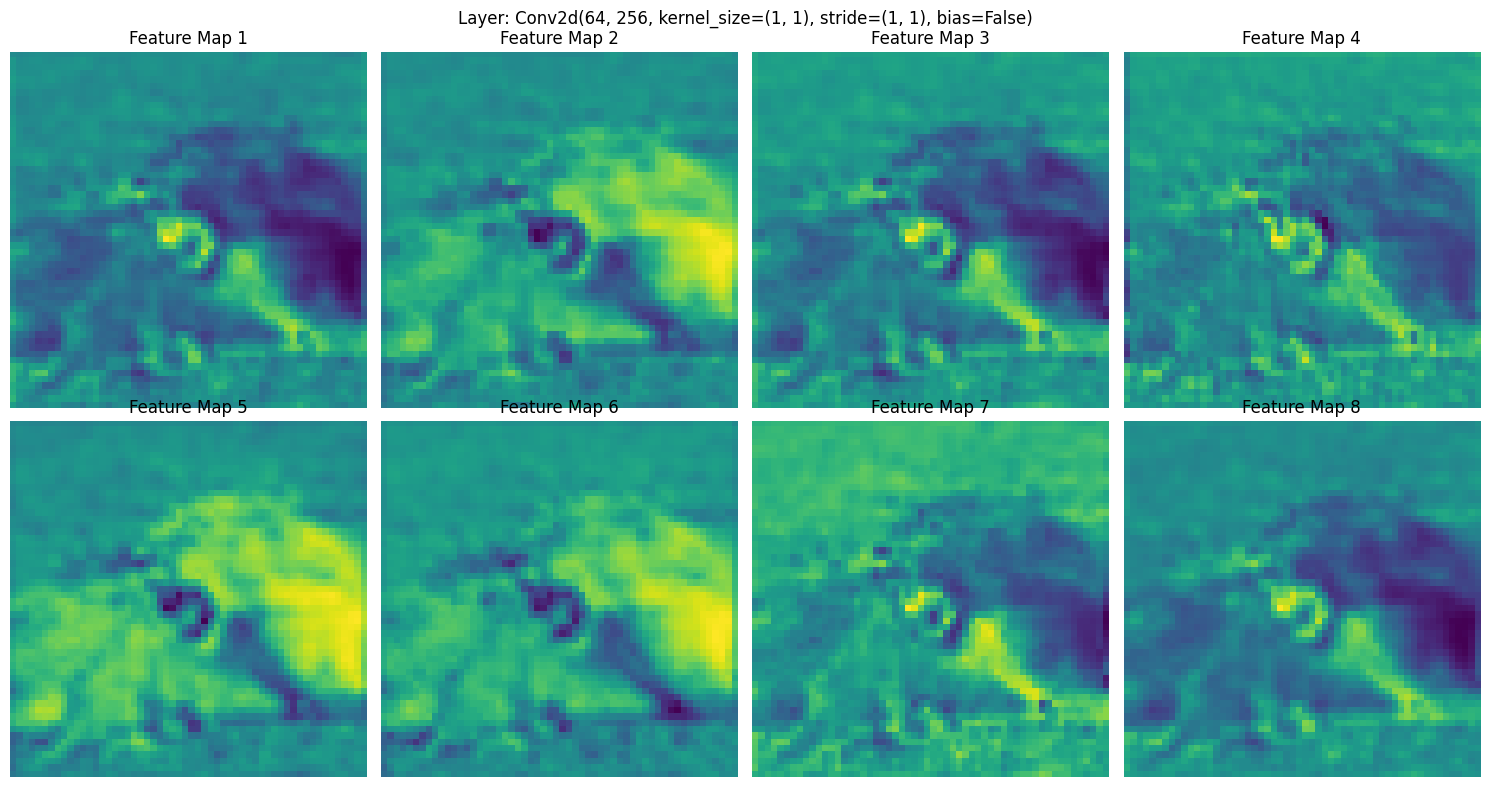

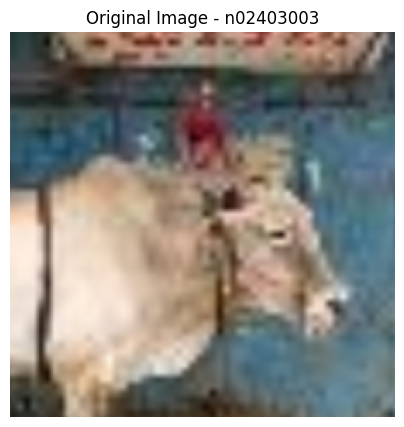


Predictions for n02403003:
345: 10.18%
690: 5.00%
51: 1.62%

Feature maps for n02403003:

Layer: Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


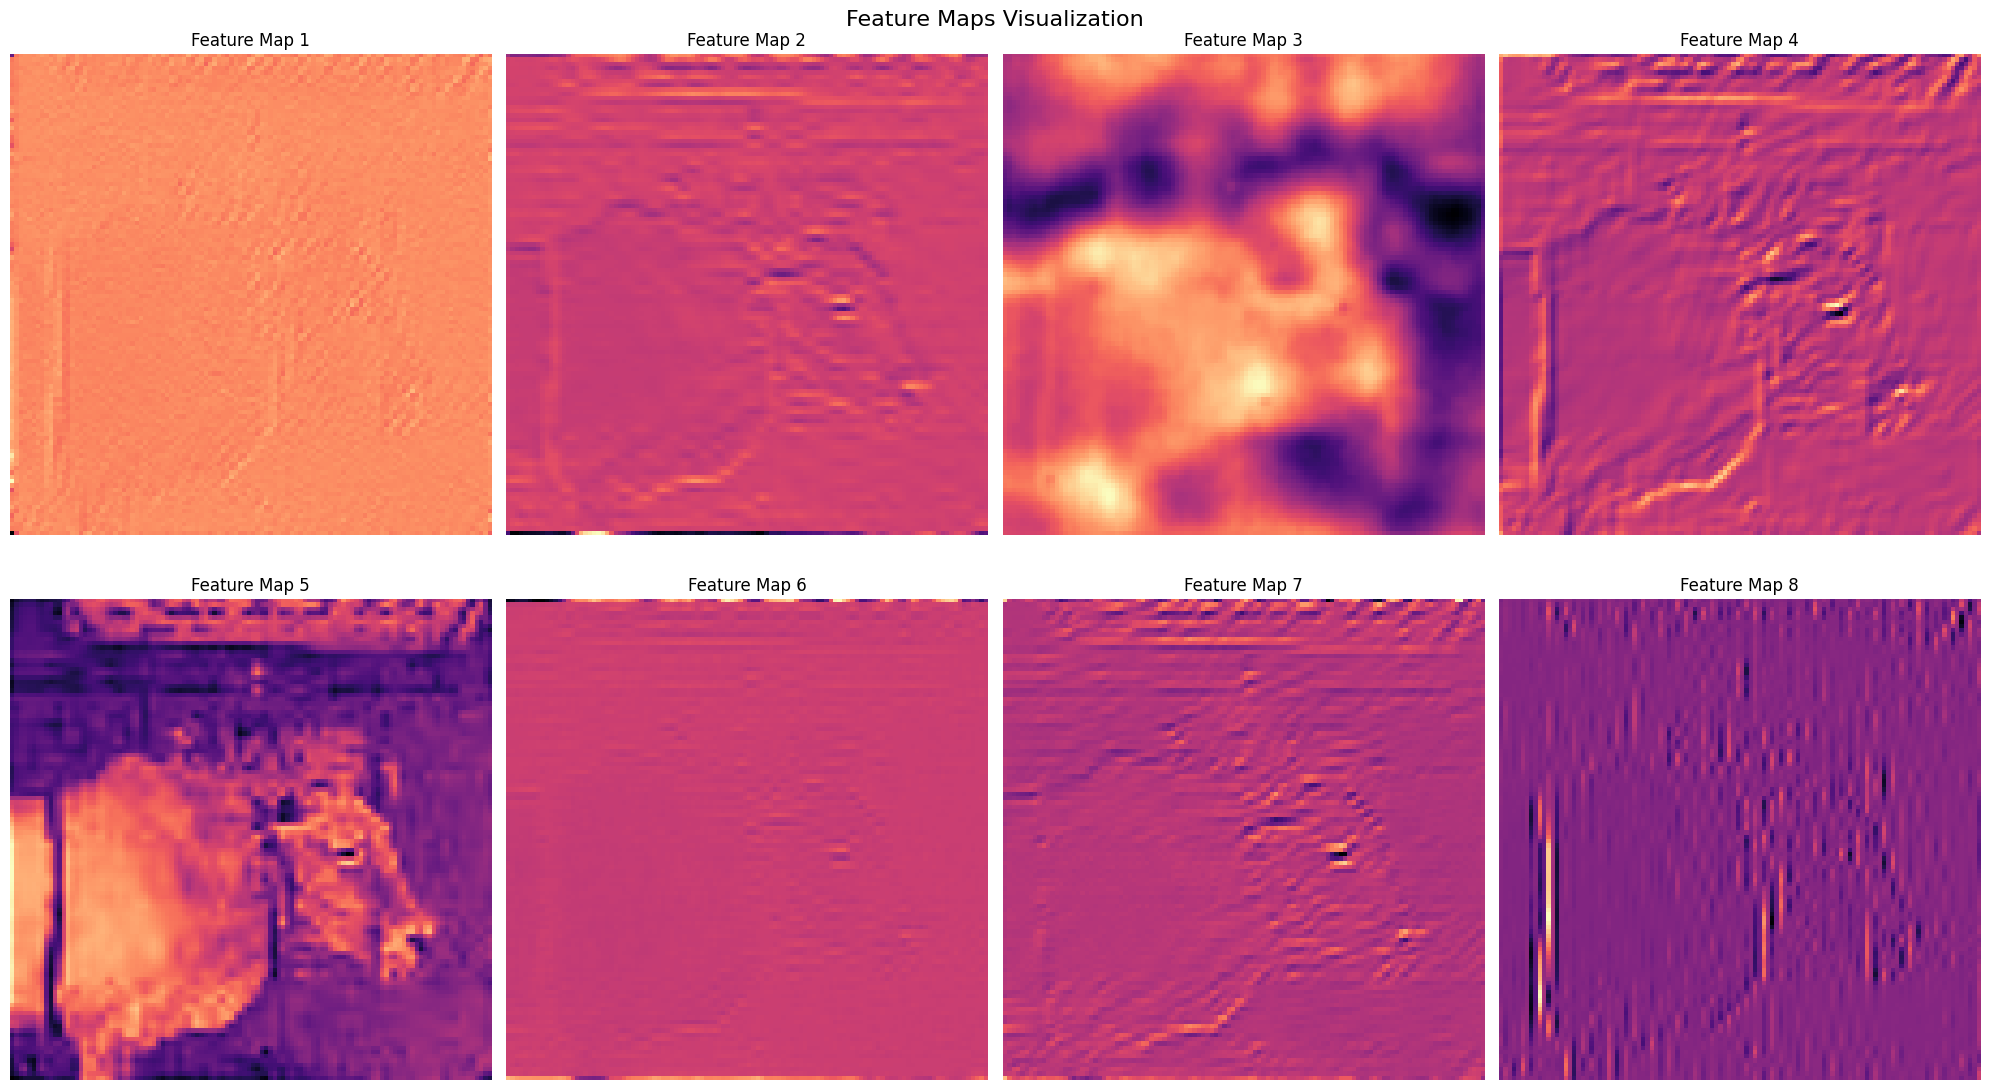

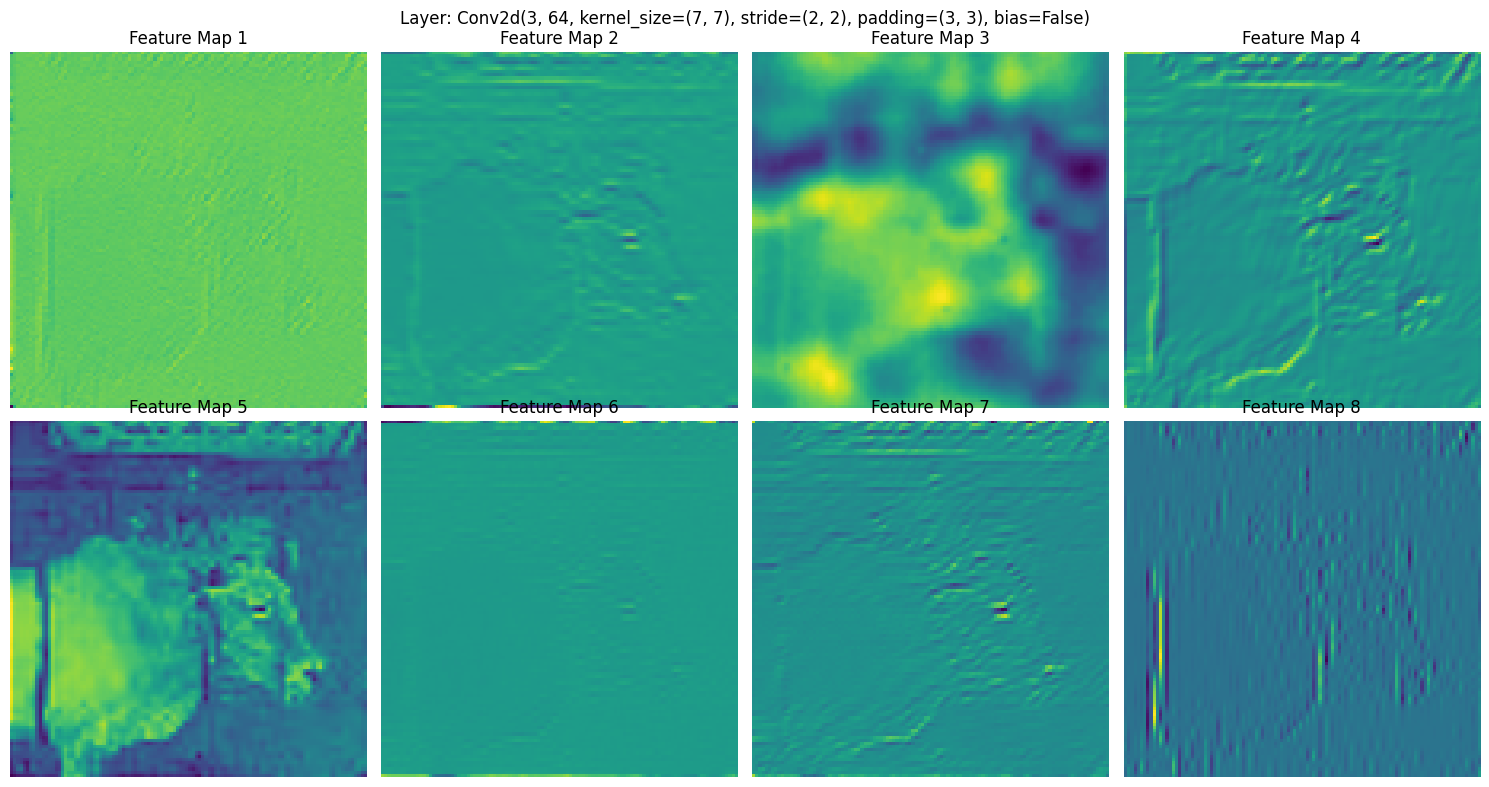


Layer: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)


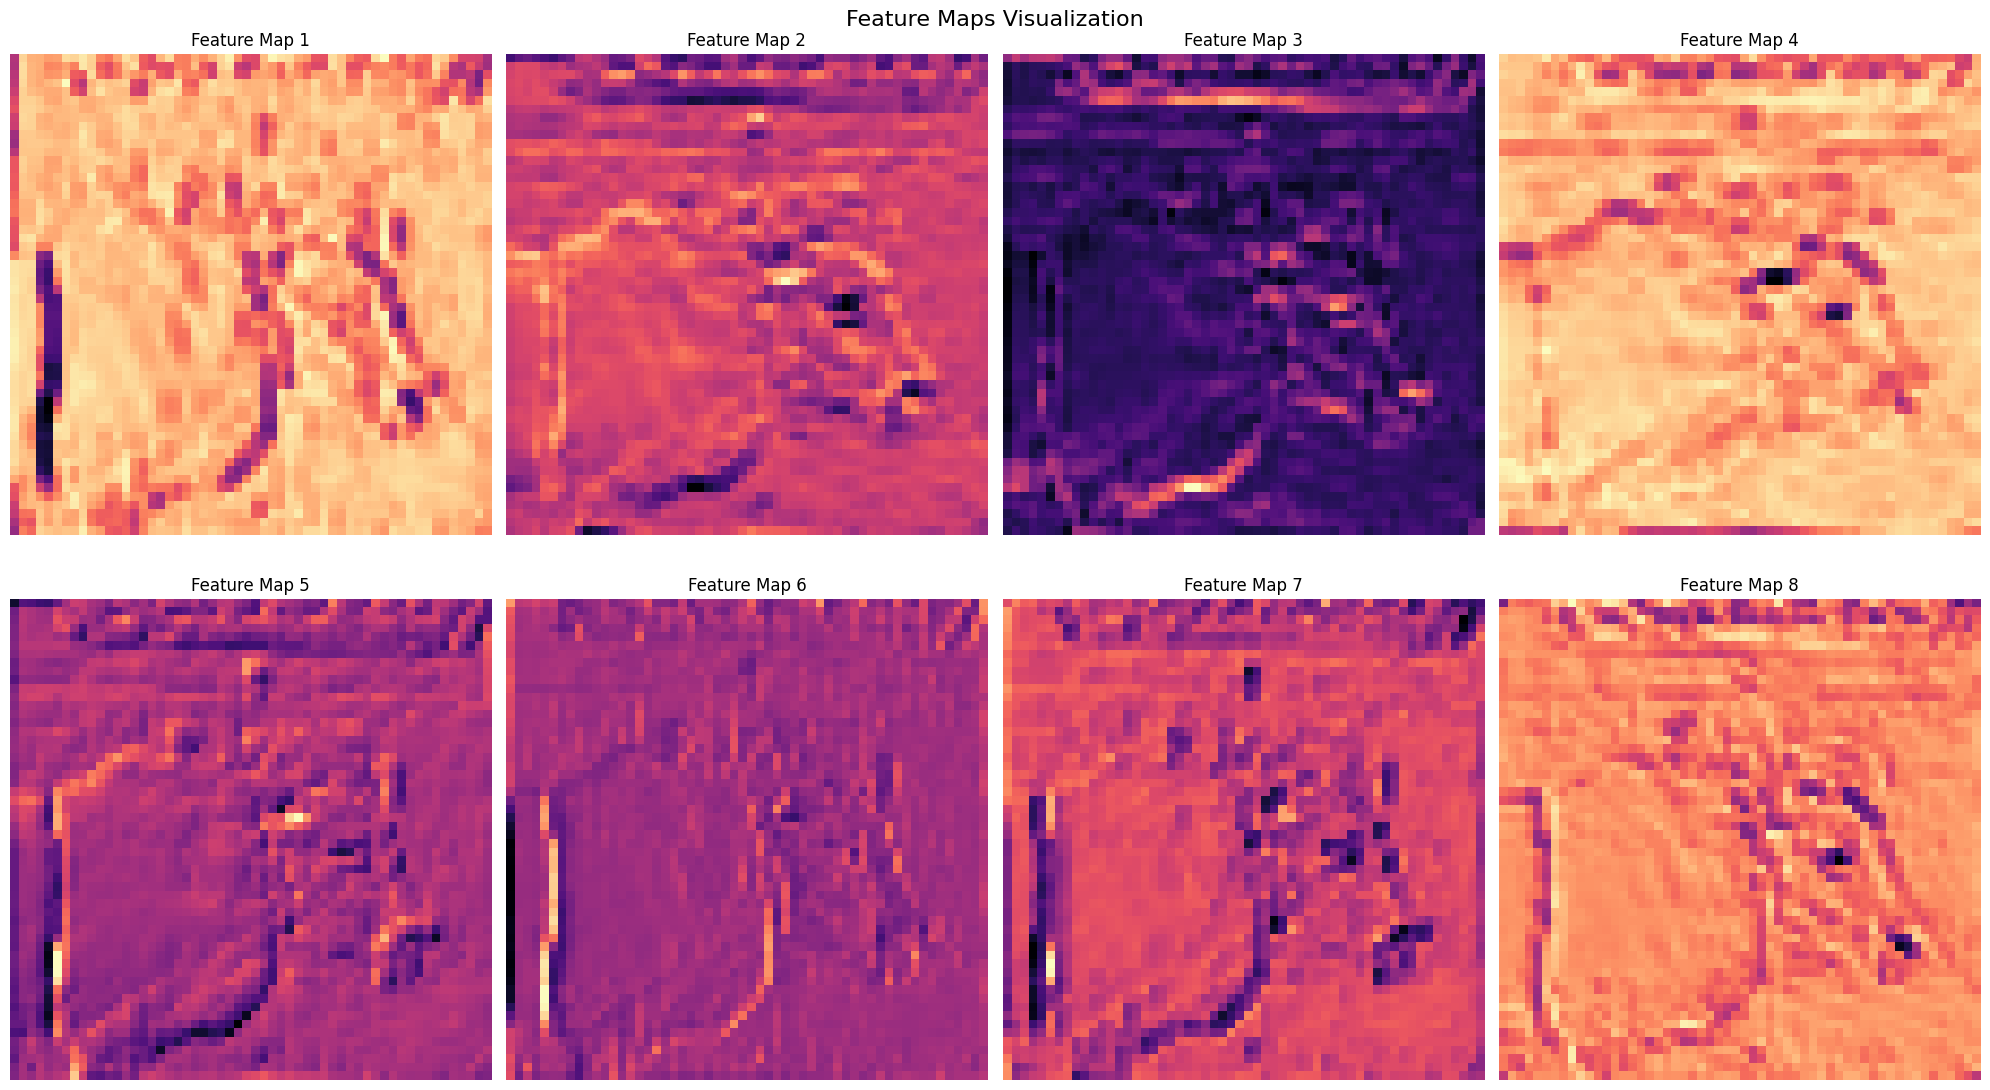

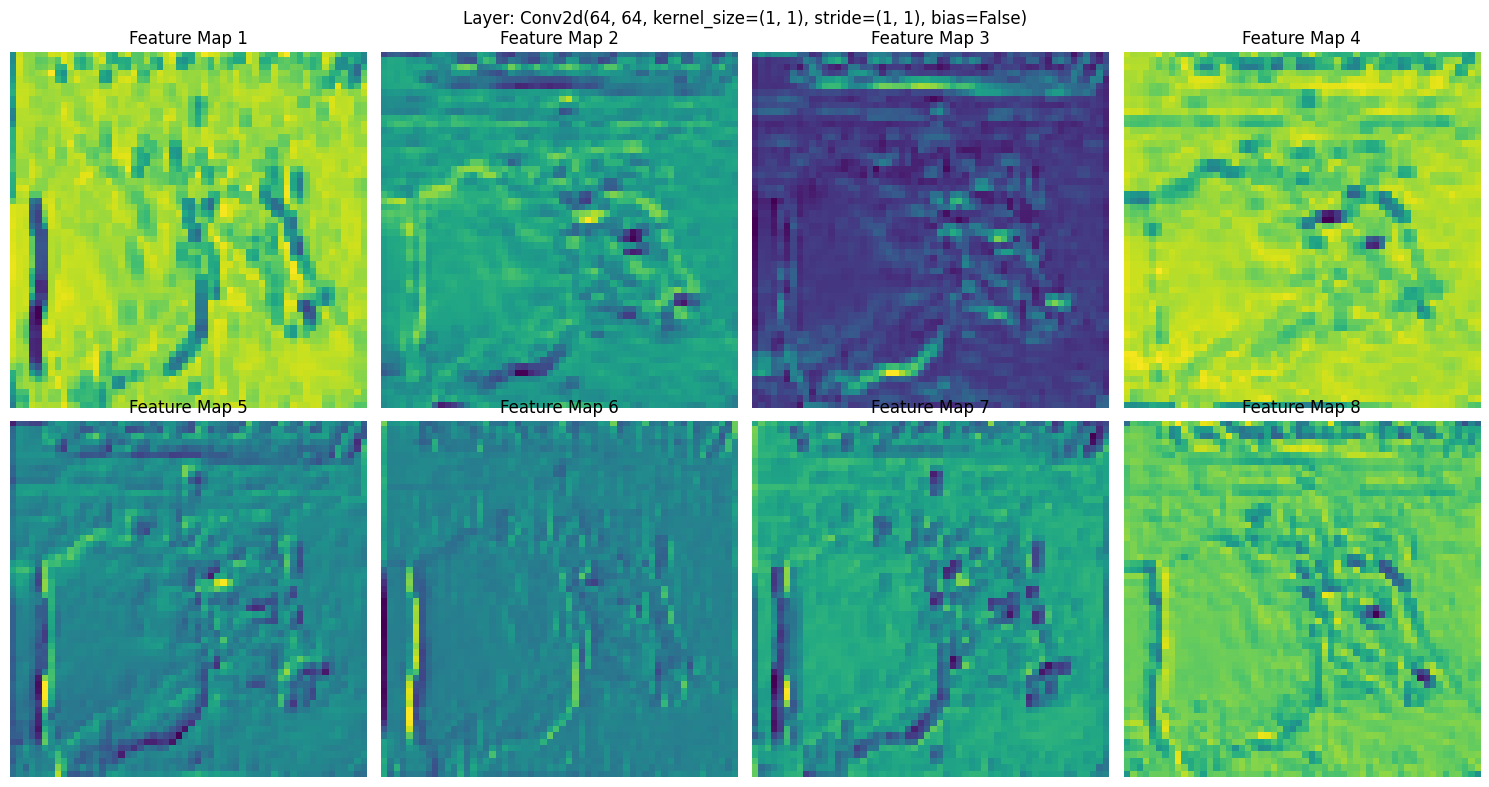


Layer: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


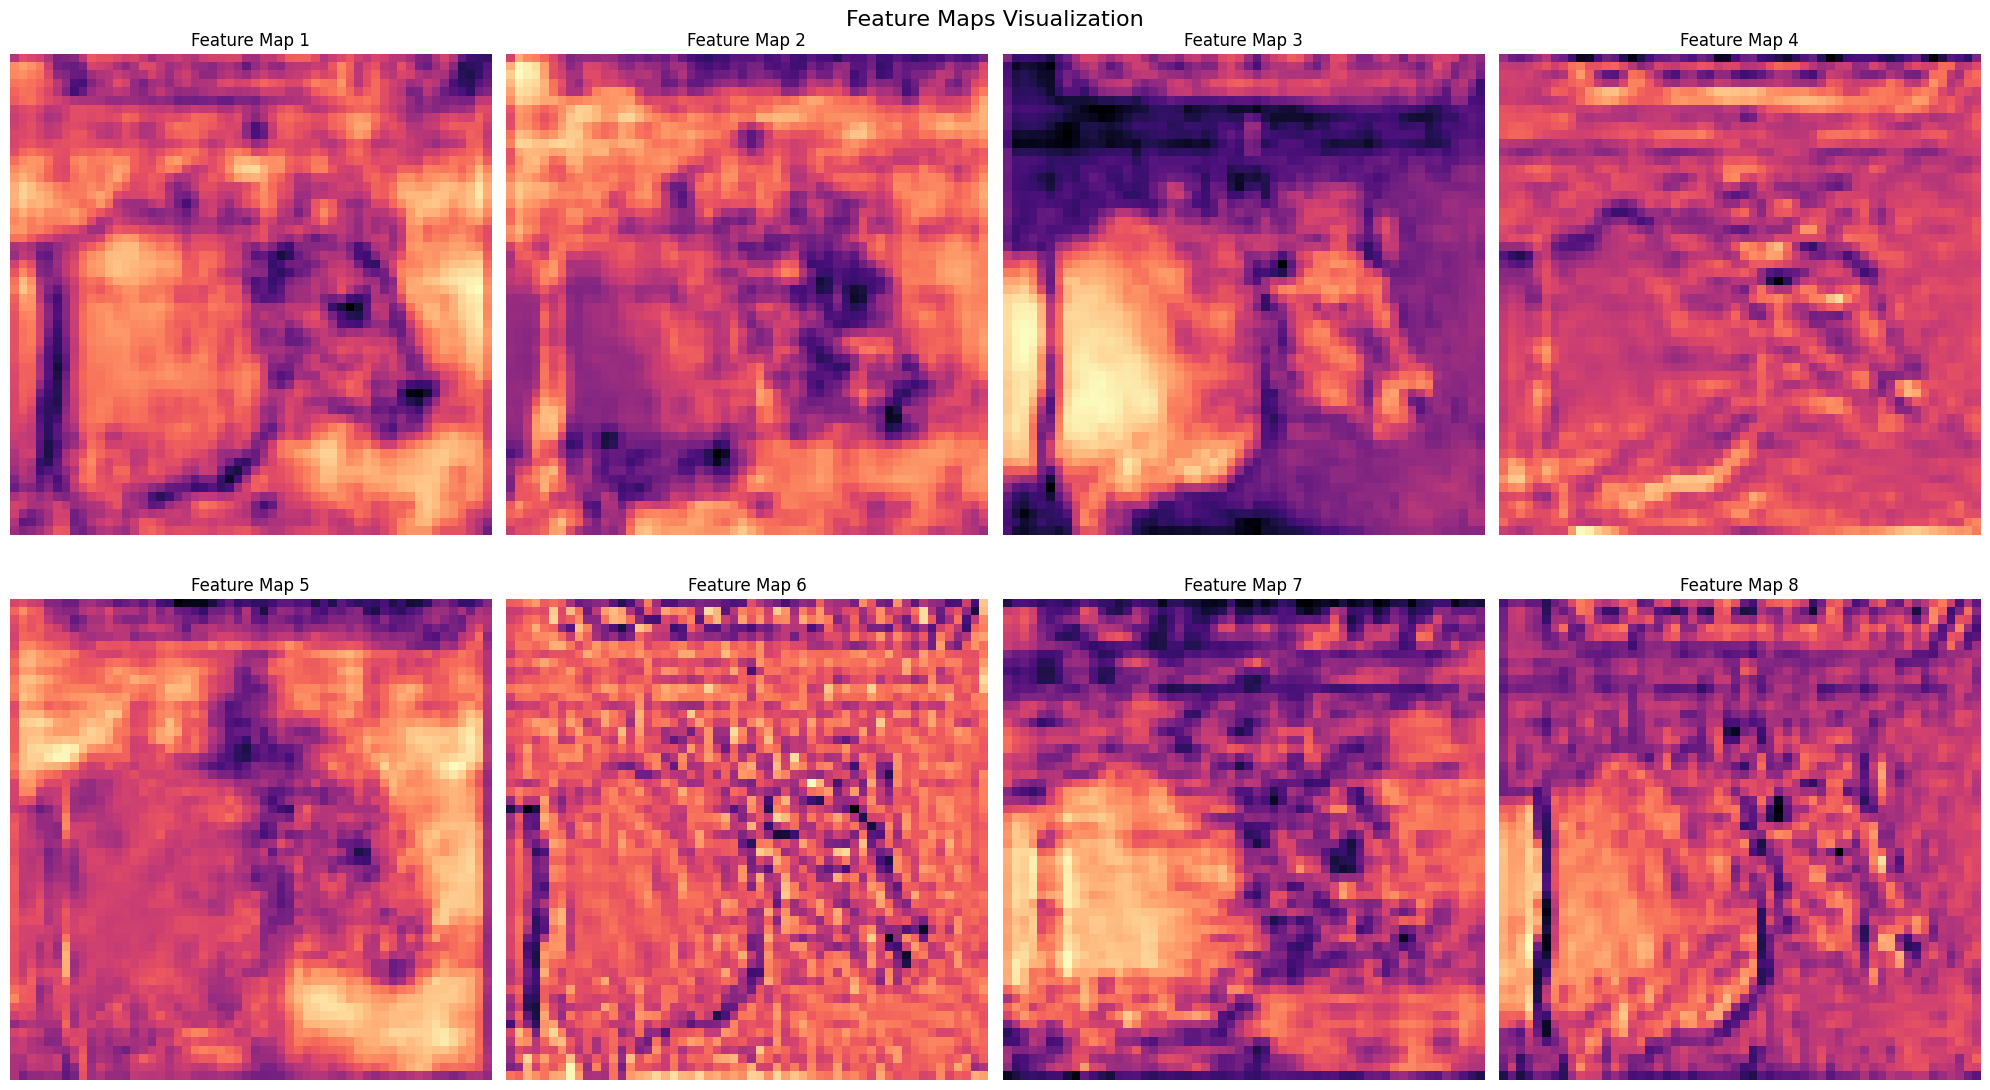

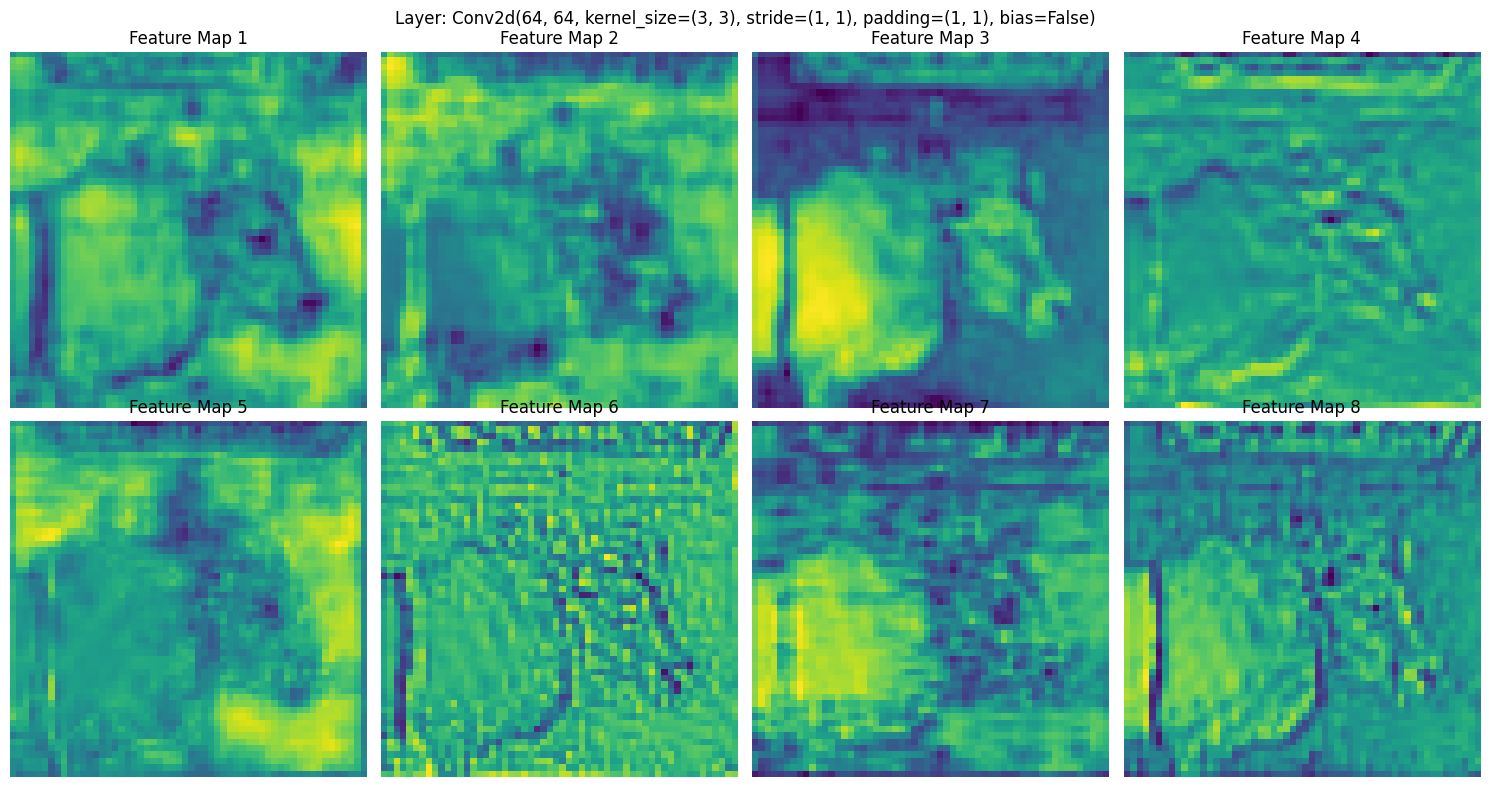


Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


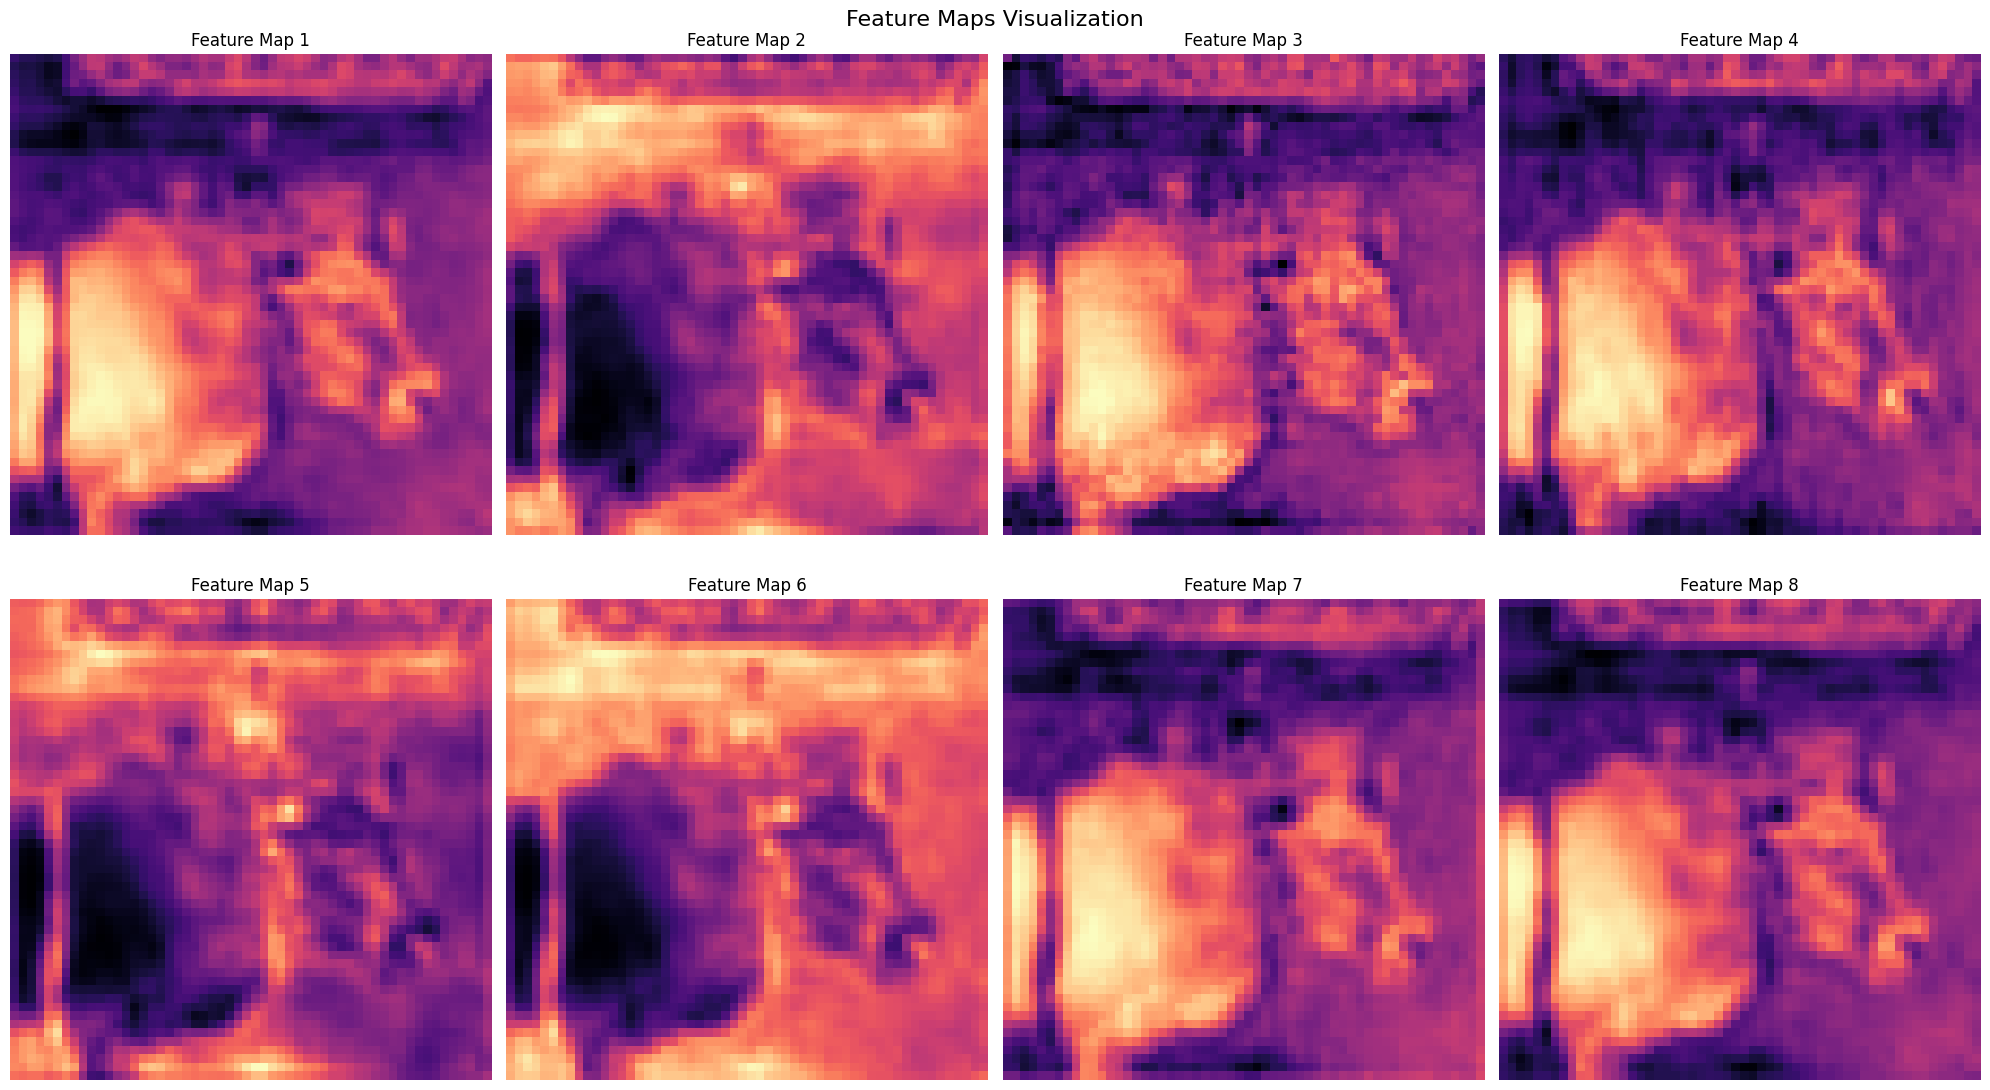

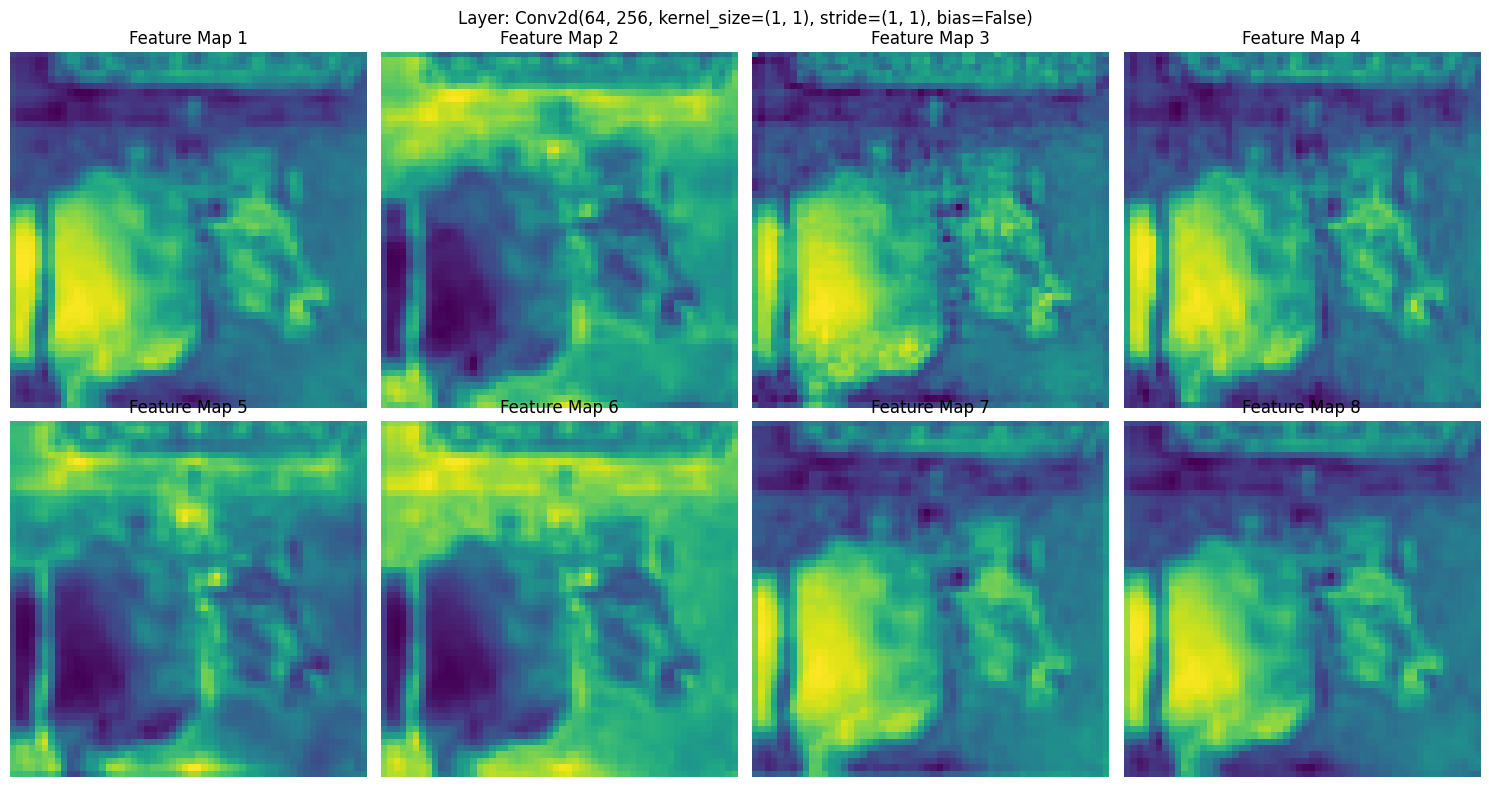


Layer: Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


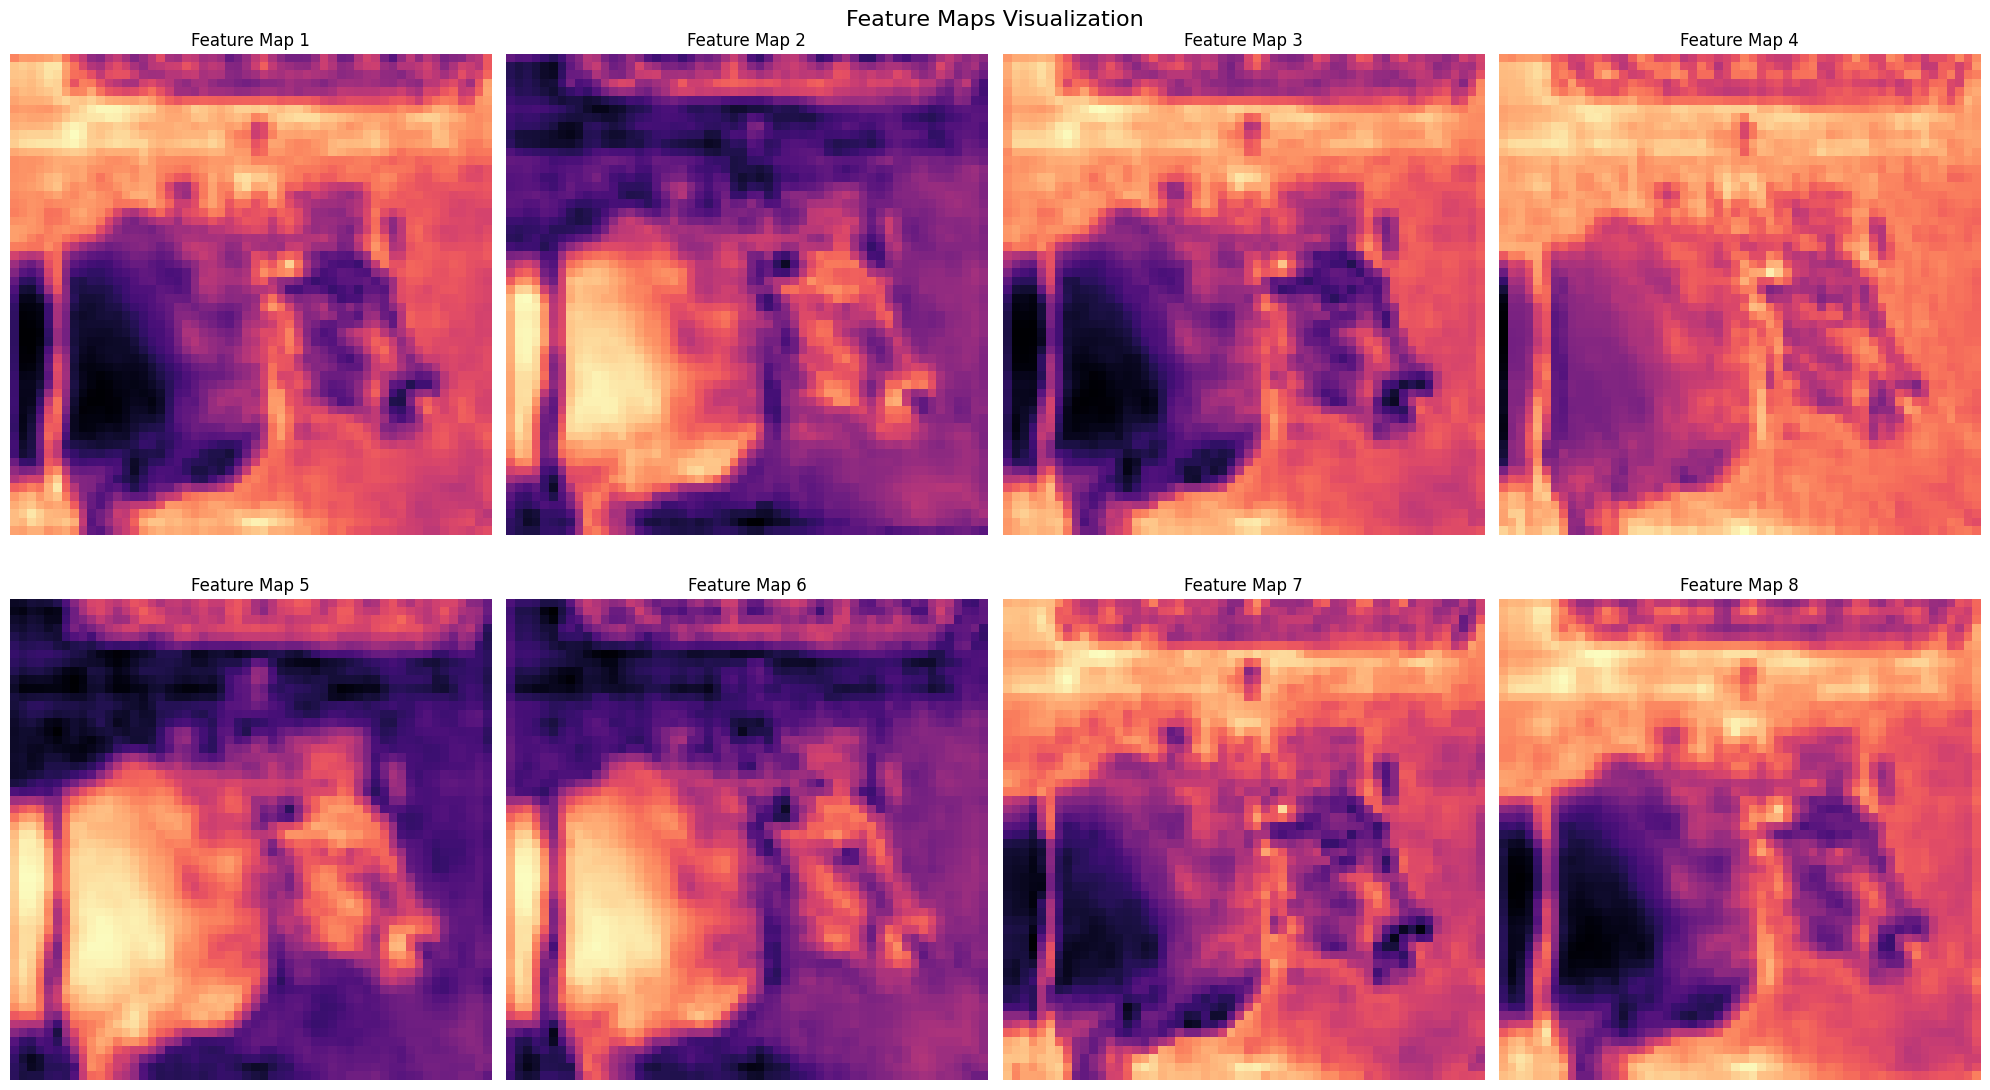

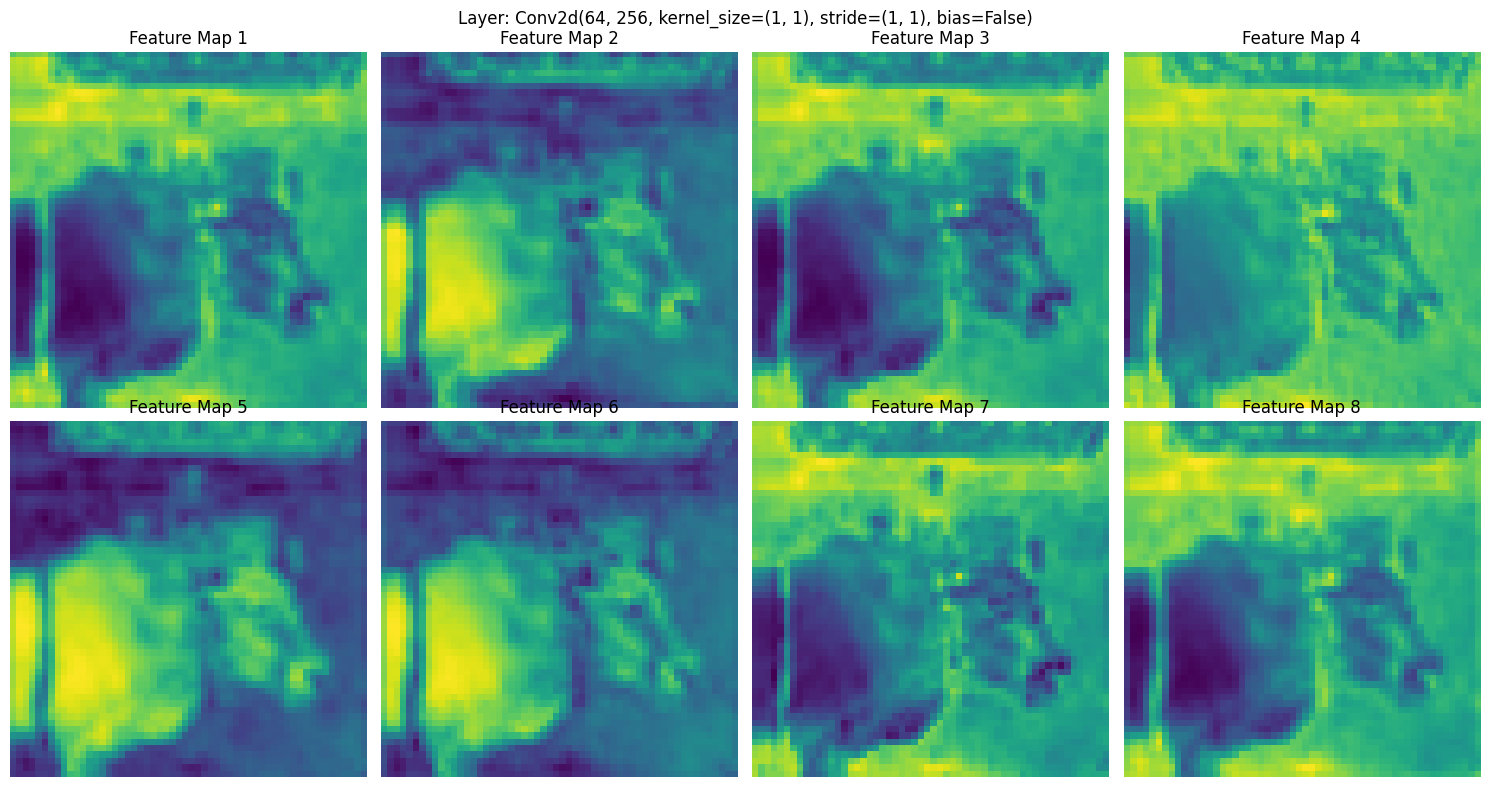

Processing images:  20%|██        | 1/5 [00:17<01:08, 17.25s/it]


In [11]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Create output directory for visualizations
output_dir = "feature_visualizations"
os.makedirs(output_dir, exist_ok=True)

# Load pre-trained model

model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

model.eval()

# Initialize feature extractor
feature_extractor = FeatureExtractor(model)

# Classification and feature visualization
with torch.no_grad():
    processed_images = 0

    for images, labels in tqdm(dataloader, desc="Processing images"):
        if processed_images >= 1:  # Limit to 3 images
            break

        # Get predictions
        outputs = model(images)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        top3_prob, top3_catid = torch.topk(probabilities, 3, dim=1)

        # Get features
        features = feature_extractor.get_features(images)

        # Display results for each image
        for idx, (label, probs, cats) in enumerate(zip(labels, top3_prob, top3_catid)):
            if processed_images >= 3:  # Check limit for individual images
                break

            # Display original image
            plt.figure(figsize=(5, 5))
            img_display = images[idx].cpu().permute(1, 2, 0)
            # Denormalize the image
            img_display = img_display * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            img_display = torch.clamp(img_display, 0, 1)
            plt.imshow(img_display)
            plt.title(f"Original Image - {label}")
            plt.axis('off')
            plt.savefig(os.path.join(output_dir, f'original_image_{processed_images}.png'))
            plt.show()

            print(f"\nPredictions for {label}:")
            for p, c in zip(probs, cats):
                print(f"{c}: {p.item() * 100:.2f}%")

            # Visualize features for first 5 layers
            print(f"\nFeature maps for {label}:")
            for name, feature_maps in list(features.items())[:5]:
                print(f"\nLayer: {name}")
                visualize_features(feature_maps[idx:idx + 1])
                plt.figure(figsize=(15, 8))
                for f_idx in range(min(8, feature_maps.shape[1])):
                    plt.subplot(2, 4, f_idx + 1)
                    plt.imshow(feature_maps[idx, f_idx].detach().cpu().numpy(), cmap='viridis')
                    plt.axis('off')
                    plt.title(f'Feature Map {f_idx + 1}')
                plt.suptitle(f'Layer: {name}')
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f'features_{processed_images}_{name}.png'))
                plt.show()
        processed_images += 1


# Clean up
feature_extractor.remove_hooks()


In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The task is to modify the ResNet50 model to get embeddings by removing the final linear layer (fc) and getting the output from the average pooling layer, which will give us a 2048-dimensional feature vector for each image.

In [13]:
data_dir

'tiny_imagenet_subset\\tiny_imagenet_subset\\tiny-imagenet-200\\train'

In [14]:
sample_images = defaultdict(list)
for class_dir in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_dir)
    print(class_path)
    if os.path.isdir(class_path):
        for img_file in os.listdir(os.path.join(class_path, 'images')):
            sample_images[class_dir].append(os.path.join(class_path, 'images', img_file))
            # sample_images[class_dir] = [os.path.join(class_path, 'images', img_file)]

tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n01443537
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n01774750
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02056570
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02129165
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02403003
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02410509
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02769748
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n02814533
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n03584254
tiny_imagenet_subset\tiny_imagenet_subset\tiny-imagenet-200\train\n04259630


In [15]:
dataset = ImageNetSubset(sample_images, transform=transform)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

In [17]:
# Create ResNet50 model for embedding extraction
def get_resnet_embeddings(images):
    # Get embeddings before the final fc layer
    embeddings = []

    # Use existing model but remove final fc layer
    embedding_model = torch.nn.Sequential(*list(model.children())[:-1])
    embedding_model.eval()

    with torch.no_grad():
        # Forward pass and flatten the output
        features = embedding_model(images)
        embeddings = features.squeeze()

    return embeddings

labels = []
# Example usage with existing dataloader
with torch.no_grad():
    for images, label in dataloader:
        # Get 2048-dimensional embeddings
        image_embeddings = get_resnet_embeddings(images)
        labels.append(label)
        print(f"Embeddings shape: {image_embeddings.shape}")

Embeddings shape: torch.Size([1000, 2048])


This code:
1. Creates a new model by removing the final fully connected layer
2. Uses the average pooling output (2048-dimensional vector) as embeddings
3. Returns flattened embeddings that can be used for downstream tasks
4. The output shape will be [batch_size, 2048]


In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [19]:
label_ = LabelEncoder().fit_transform(label)

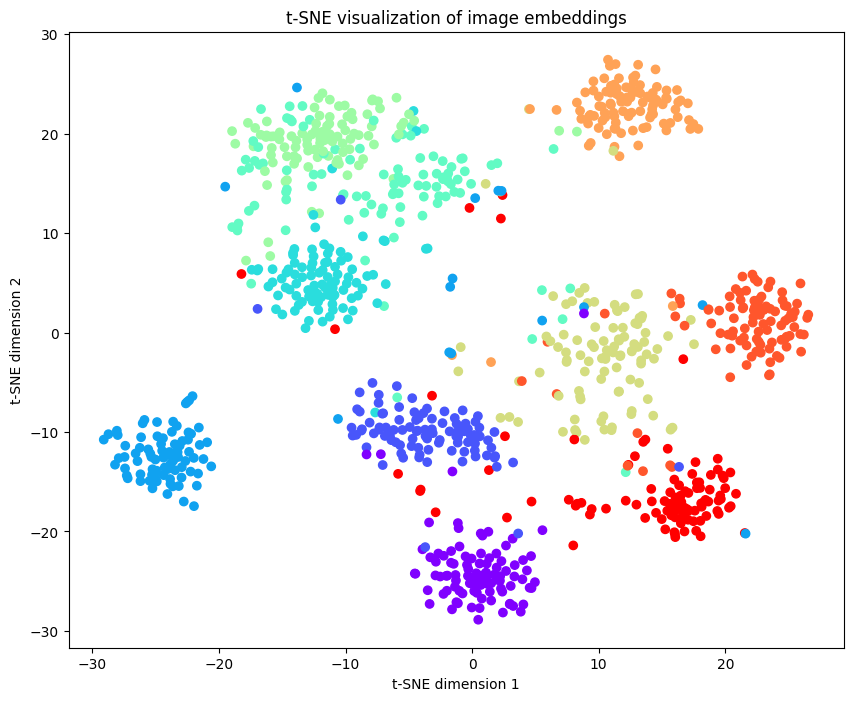

In [20]:
# Convert embeddings to numpy and create t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(image_embeddings.cpu().detach().numpy())

# Create scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=label_, cmap='rainbow')
plt.title('t-SNE visualization of image embeddings')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.show()

The above code:
1. Installs scikit-learn which contains t-SNE implementation
2. Creates 2D t-SNE projection from the high-dimensional embeddings
3. Visualizes the projections as a scatter plot


Feature Visualizations: https://distill.pub/2017/feature-visualization/